In [247]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [248]:
fcs =  [round(i*0.04,2) for i in range(20)]


In [249]:

import os 
import pandas as pd
import numpy as np
# git 
os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")
from triqler_output_to_df import parse_triqler
from q_value import qvalues


# db
#from get_protein_specie_map_from_fasta import fasta_to_protein_specie_map
os.chdir("/home/ptruong/git/dia_sum/database")
#protein_specie_map = fasta_to_protein_specie_map("2021-04-27-decoys-reviewed-contam-UP000005640-UP000002311-UP000000625.fas")
#protein_specie_map = protein_specie_map.set_index("protein").T.to_dict()
# MSFragger 
#os.chdir("/hdd_14T/data/PXD002952/res_20210530_DIAUmpire/MSFragger")
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")


In [250]:
# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]
def decoy_mapper(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

In [251]:
df = pd.read_csv("report.tsv", sep = "\t")
triq = pd.read_csv("triqler_input_diann_searchScore_Qvalue.csv", sep = "\t")                      



In [252]:

def compute_triqler_top3_submodule(run):
    triq_run = triq[triq.run == run]   
    triq_run.searchScore = np.e**(-1 * triq_run.searchScore) #re-convert searchScore, because our triqler_input has -np.log(-Q.Value) from diann result.tsv as searchScore
    triq_run = triq_run[triq_run["searchScore"] < 0.01]
    
    def triqler_top3(triq_run):
        res = triq_run.groupby("proteins")["intensity"].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan).reset_index()
        return res
    
    def triqler_printout_unique_peptides_proteins(run):
        #triq_run = triq[triq.run == run]
        #print(len(triq_run[triq_run["searchScore"] < 0.01].peptide.unique()))
        condition = triq_run.condition.unique()
        print(f"run : {run} - condition : {condition}")
        print(f"Unique peptides detected: {len(triq_run.peptide.unique())}")
        print(f"Unique proteins detected: {len(triq_run.proteins.unique())}")
        print()
    
    triqler_printout_unique_peptides_proteins((run))
    
    res = triqler_top3(triq_run)
    #def remove_decoy_tag_protein(protein):
    #    if protein.split("_")[0] == "DECOY":
    #        return protein.split("_")[1]
    #    else: return protein.split("_")[0]
    
    #res["proteins_nonTagged"] = res.proteins.map(remove_decoy_tag_protein)
    #res["specie"] = res.proteins_nonTagged.map(protein_specie_map)
    experiment_id = triq_run.run.unique()[0]
    sample_id = triq_run.condition.unique()[0]
    #res["ProteinName"] = res["proteins"]
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    #res = res.set_index(["specie", "ProteinName"])
    #res = res.drop(["proteins", "proteins_nonTagged"], axis = 1)
    df = pd.DataFrame(res.values)
    
    specie_map = lambda x: x.split("_")[-1]
    protein_map = lambda x: x.split("_")[-2]
    res["specie"] = res.proteins.map(specie_map)
    res["ProteinName"] = res.proteins
    res = res.drop(["proteins"], axis = 1)
    res = res.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(res.values, columns = midx, index = res.index)
    return df
#df = compute_triqler_top3_submodule(run)

dfs = []
for run in triq.run.unique():
    dfs.append(compute_triqler_top3_submodule(run))
     
df = pd.concat(dfs, axis = 1)
df # Check why we have more species than in the fasta??? Is this because of how we build the spectral library?
df = df[df.index.get_level_values("specie").isin(["HUMAN", "ECOLI", "YEAST"])]

#df[df.index.get_level_values("specie").isin(["HUMAN"])]
#df[df.index.get_level_values("specie").isin(["ECOLI"])]
#df[df.index.get_level_values("specie").isin(["YEAST"])]

df = pd.concat(dfs, axis = 1)



A = df[df.iloc[:, df.columns.get_level_values("sample_id") == 1].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == 1]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == 2].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == 2]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]

import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res



import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()


/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 002-Pedro - condition : [1]
Unique peptides detected: 21036
Unique proteins detected: 3377



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 003-Pedro - condition : [2]
Unique peptides detected: 21243
Unique proteins detected: 3358



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 004-Pedro - condition : [1]
Unique peptides detected: 20783
Unique proteins detected: 3350



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 005-Pedro - condition : [2]
Unique peptides detected: 21325
Unique proteins detected: 3381



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 006-Pedro - condition : [1]
Unique peptides detected: 21040
Unique proteins detected: 3368



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 007-Pedro - condition : [2]
Unique peptides detected: 21248
Unique proteins detected: 3356



In [253]:

import time
from triqler_output_to_df import  parse_triqler

os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        # Added specie mapping... need to check the problem with BOVIN, SCVLA proteins???
        #print(df_triq)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        df_triq["protein"] = df_triq["protein"] + "_" + df_triq["specie"]
        df_triq = df_triq[df_triq["specie"].isin(["HUMAN", "ECOLI", "YEAST"])]
        df_triq = df_triq[df_triq.q_value < q_val]
        #df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAST", "ECOLI"])
    return df


#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI"])
        res.append(df_res)
    return res
fcs =  [round(i*0.04,2) for i in range(20)]

res = get_DE_for_fcs( fcs = fcs)


In [254]:

os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")

msqrob = pd.read_csv("msqrobsum_result.csv", sep = "\t")
msqrob["specie"] = msqrob.proteins.map(specie_mapper)

msqrob

def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (msqrob_fc["qvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res


In [255]:
def msstats_pq_data(ms, fc):
    # ms = pd.read_csv("msstats.csv")
    ms_gt = ms[ms.log2FC > fc]
    ms_lt = ms[ms.log2FC < -fc]
    ms_fc = pd.concat([ms_gt, ms_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (ms_fc["adj.pvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# MSSTATS
#os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msstats_results")

ms = pd.read_csv("msstat_output_filtered.csv")
ms["specie"] = ms.Protein.map(specie_mapper)

In [256]:
len(ms)

3381

In [257]:
ms.replace([np.inf, -np.inf], np.nan, inplace=True)

In [258]:
ms.dropna(subset=["log2FC"], inplace = True)

In [259]:

#Rewrite this to function subplot
def plot_pq_specie(specie, fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            res[i].sum(axis=1).plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final, fc_treshold = fc)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            res[i][specie].plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()



#Rewrite this to function subplot
def plot_pq_specie_FP(specie, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        if specie == "all":
            df = pq_data(df_final, fc_treshold = fc)
            df_triq = res[i].sum(axis=1)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_triq = res[i][specie]
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)

        # False positives
        df_FP = pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
        df_triq_FP = res[i]["HUMAN"]
        df_ms_FP = msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc)
        df_msqrob_FP = msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc)
        """
        if fc >= 1.0:
            df_FP_yeast = pq_data(df_final[df_final.index.get_level_values("specie") == "YEAST"], fc_treshold = fc)
            df_triq_FP_yeast = res[i]["YEAST"]
            df_ms_FP_yeast = msstats_pq_data(ms[ms.specie == "YEAST"], fc = fc)
            df_msqrob_FP_yeast = msqrob_pq_data(msqrob[msqrob.specie == "YEAST"], fc = fc)
            
            df_FP += df_FP_yeast
            df_triq_FP += df_triq_FP_yeast
            df_ms_FP += df_ms_FP_yeast
            df_msqrob_FP += df_msqrob_FP_yeast
        """ 
        df_triq.plot(ax = axs[row,col], style = "b") #triqler data plot
        axs[row, col].plot(df.index, df.DE, "k") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob
        
        # Plot False positives
        #res[i]["HUMAN"].plot(ax = axs[row,col], style="b--") #triqler data plot
        df_triq_FP.plot(ax = axs[row, col], style="b--")
        axs[row, col].plot(df.index, df_FP.DE, "k--") # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms_FP.DE, "g--") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob_FP.DE, "r--") # plot msqrob
        

        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob",
        #                              "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStat", "mSqRob",
                                      "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#FP ratio
def plot_ratio_FP_DE(specie, fcs):
    fig, axs = plt.subplots(4, 5,figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i].sum(axis=1))
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))        
        else:
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i][specie])
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()




#Rewrite this to function subplot
def plot_de_specie_xy(specie_x, specie_y, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        df_triq_x = res[i][specie_x]
        df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
        df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
        df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)
        
        df_triq_y = res[i][specie_y]
        df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
        df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
        df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)
        
        #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
        #axs[row, col].plot(df.index, df.DE) # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        
        axs[row, col].plot(df_triq_x.values, df_triq_y.values)
        axs[row, col].plot(df_x.values, df_y.values)
        axs[row, col].plot(df_ms_x.values, df_ms_y.values)
        axs[row, col].plot(df_msqrob_x.values, df_msqrob_y.values)
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel(f"n - Differentially expressed {specie_x}")
        axs[row, col].set_ylabel(f"n - Differentially expressed {specie_y}")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins specie ratio ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()

## N-differentially expressed proteins
This is used to show number of differentially expresed proteins

Text(0.5, 0.98, 'Differentially expressed protein (DIAUmpire(SE) -> MSFragger -> EasyPQP -> DIA-NN)')

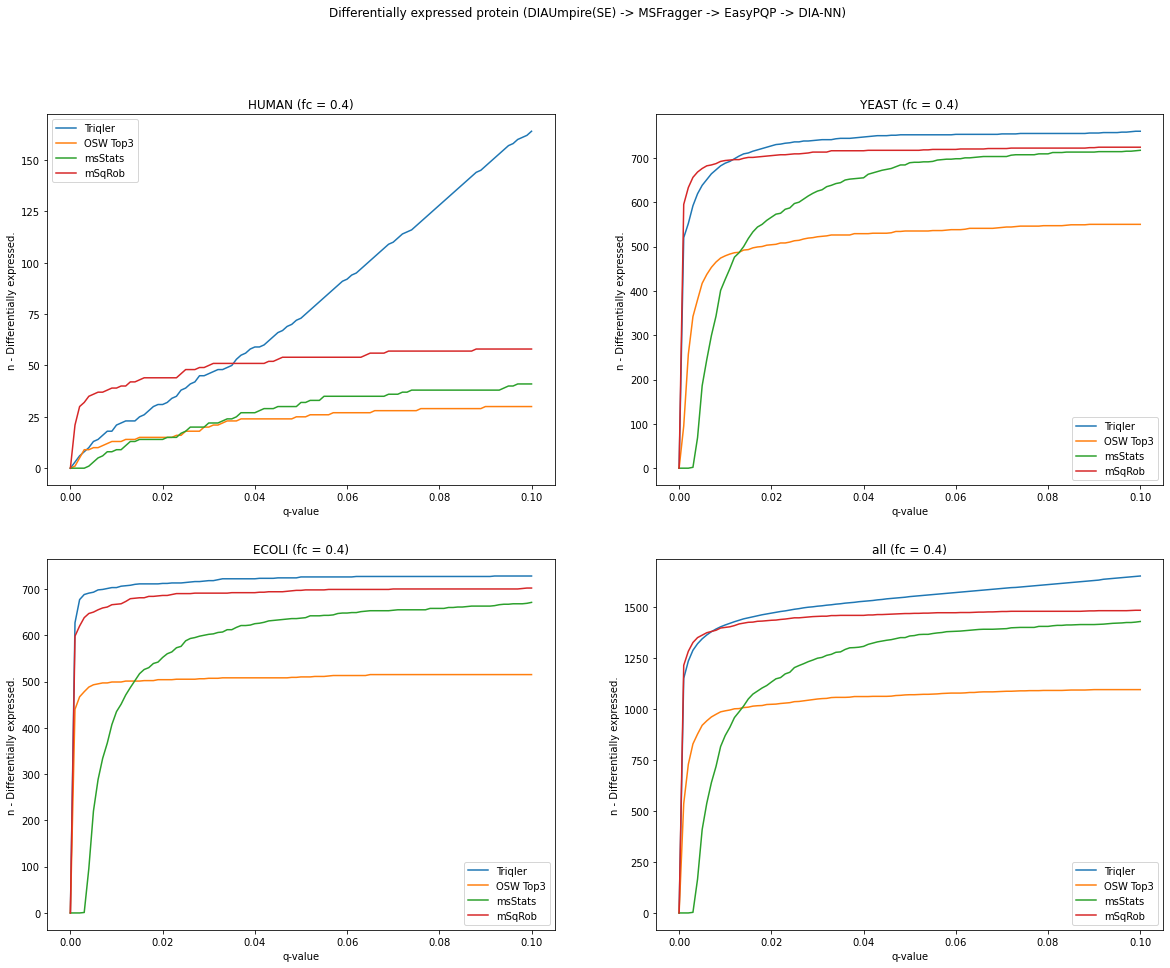

In [260]:
row = 0
col = 0

fig, axs = plt.subplots(2,2, figsize = (20,15))
fc = 0.4

def plot_pq(specie, row, col):
    triq = res[10] # fcs[10] is 0.4 in this case
    
    if specie == "all":
        df = pq_data(df_final, fc_treshold = 0.4)
        #df_triq = res[i].sum(axis=1)
        df_ms = msstats_pq_data(ms, fc = 0.4)
        df_msqrob = msqrob_pq_data(msqrob, fc = 0.4)
        triq.sum(axis=1).plot(ax = axs[row,col])

    else:
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = 0.4)
        df_ms = msstats_pq_data(ms[ms.specie == specie], fc = 0.4)
        df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = 0.4)
        triq[specie].plot(ax = axs[row,col])
    
    axs[row, col].plot(df.index, df.DE) # plot osw top3
    axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
    axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
    axs[row, col].set_title(f"{specie} (fc = {0.4})")
    axs[row, col].set_xlabel("q-value")
    axs[row, col].set_ylabel("n - Differentially expressed.")
    
plot_pq("HUMAN", row = 0, col = 0)
plot_pq("YEAST", row = 0, col = 1)
plot_pq("ECOLI", row = 1, col = 0)
plot_pq("all", row = 1, col = 1)

plt.suptitle("Differentially expressed protein (DIAUmpire(SE) -> MSFragger -> EasyPQP -> DIA-NN)")


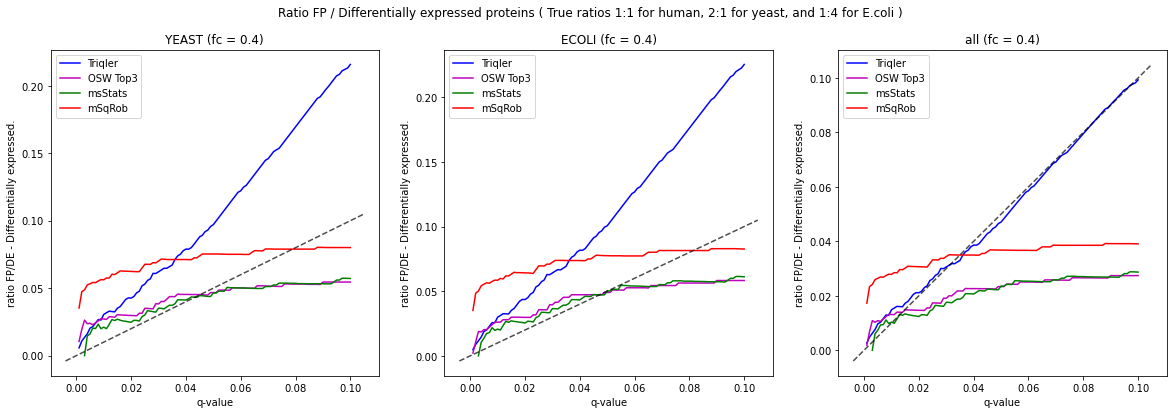

In [261]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
fc = 0.4
#Rewrite this to function subplot

def plot_ratio_FP_DE(specie,col):


    if specie == "all":
        df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final, fc_treshold = fc))
        df_triq = (res[10]["HUMAN"] / 
                   res[10].sum(axis=1))
        df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms, fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob, fc = fc))        
    else:
        df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
        df_triq = (res[10]["HUMAN"] / 
                   res[10][specie])
        df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms[ms.specie == specie], fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

    df_triq.plot(ax = axs[col], style = "b") # triqler data plot
    axs[col].plot(df.index, df.DE, "m") # plot osw top3
    axs[col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
    axs[col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

    axs[col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
    axs[col].set_title(f"{specie} (fc = {fc})")
    axs[col].set_xlabel("q-value")
    axs[col].set_ylabel("ratio FP/DE - Differentially expressed.")

    def abline(slope, intercept, col):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axs[col].get_xlim())
        y_vals = intercept + slope * x_vals
        axs[col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
    abline(1,0,col)

plot_ratio_FP_DE("YEAST", 0,)
plot_ratio_FP_DE("ECOLI", 1)
plot_ratio_FP_DE("all", 2)
    
plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
plt.show()


# Protein quantity distributions
This is used to show how the data looks

In [262]:
import seaborn as sns

In [263]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")


Text(0.5, 0.98, 'Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

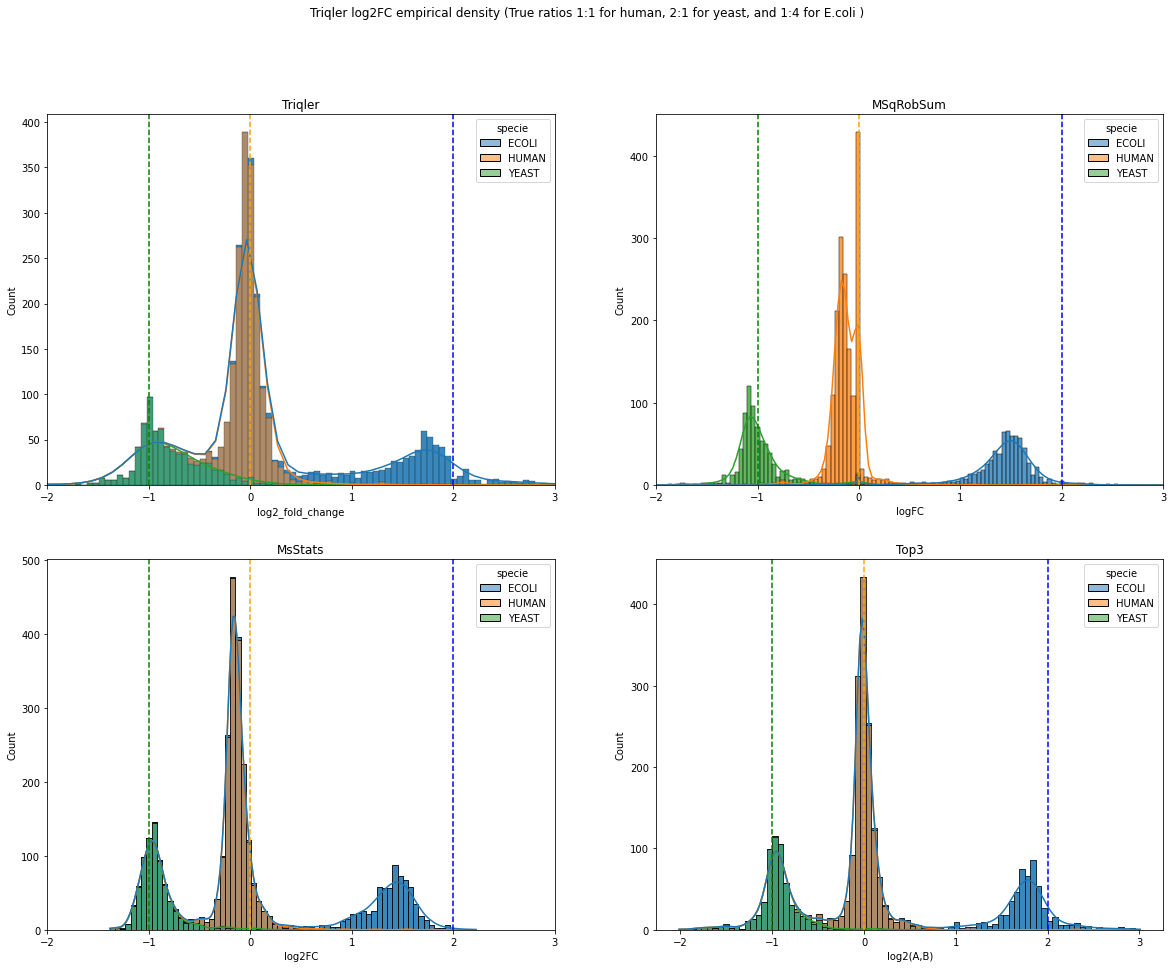

In [264]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")
q_val = 1
file = "fc_0.40"
df_triq = parse_triqler(file)
df_triq["decoy"] = df_triq.protein.map(decoy_mapper)
df_triq = df_triq[df_triq.decoy == False] # remove decoy proteins.
df_triq = df_triq[df_triq.q_value < q_val] # not filtered by q_value
df_triq["specie"] = df_triq.protein.map(specie_mapper)
df_triq.sort_values(by = "specie", inplace = True)
df_triq.log2_fold_change = -df_triq.log2_fold_change

fig, axs = plt.subplots(2, 2, figsize=(20,15))

sns.histplot(df_triq["log2_fold_change"], kde = False, ax = axs[0,0])
sns.histplot(data=df_triq, x="log2_fold_change", hue="specie", multiple="stack", kde = True, ax = axs[0,0])
axs[0,0].set_xlim([-2, 3])
axs[0,0].set_title("Triqler")

axs[0,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,0].axvline(x = -1, color = "green", linestyle = "--")
axs[0,0].axvline(x = 2, color = "blue", linestyle = "--")

msqrob.sort_values(by = "specie", inplace = True )
msqrob["specie"] = msqrob.proteins.map(specie_mapper)
sns.histplot(msqrob, x = "logFC", hue = "specie",kde = True, ax = axs[0,1])
sns.histplot(msqrob, x = "logFC", hue = "specie",kde = False, ax = axs[0,1])
axs[0,1].set_title("MSqRobSum")
axs[0,1].set_xlim([-2, 3])

axs[0,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,1].axvline(x = -1, color = "green", linestyle = "--")
axs[0,1].axvline(x = 2, color = "blue", linestyle = "--")


ms.sort_values(by = "specie", inplace = True )
sns.histplot(ms.log2FC, kde = False, ax = axs[1,0], bins = 70)
sns.histplot(data=ms, x="log2FC", hue="specie", multiple="stack", bins = 70, kde = True, ax = axs[1,0])
axs[1,0].set_title("MsStats")
axs[1,0].set_xlim([-2, 3])


axs[1,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,0].axvline(x = -1, color = "green", linestyle = "--")
axs[1,0].axvline(x = 2, color = "blue", linestyle = "--")

# add -1* to reverse histograms
sns.histplot(-1*df_final["log2(A,B)"], kde = False, ax = axs[1,1])
axs[1,1].set_title("Top3")
sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)

axs[1,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,1].axvline(x = -1, color = "green", linestyle = "--")
axs[1,1].axvline(x = 2, color = "blue", linestyle = "--")


fig.suptitle('Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

# DE specie vs DE human

This plot shows how many true positives we get compares to false positives.

Text(0.5, 0.98, 'Differentially expressed proteins specie to human ratio')

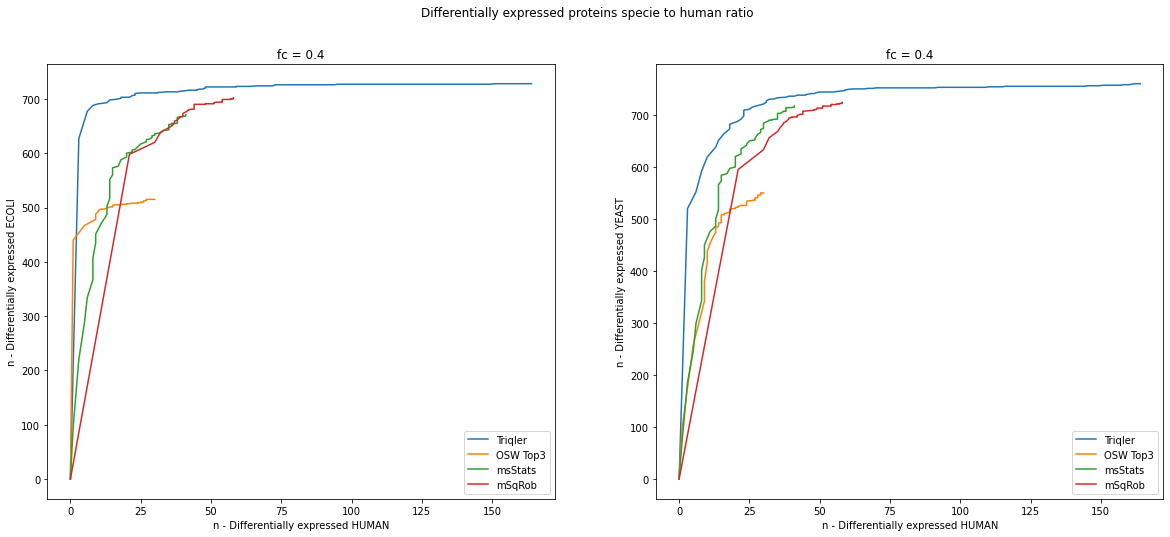

In [265]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
fc = 0.4 
#Rewrite this to function subplot

def plot_de_specie_xy(specie_x, specie_y, ax_n):
    df_triq_x = res[10][specie_x]
    df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
    df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
    df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)

    df_triq_y = res[10][specie_y]
    df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
    df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
    df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)

    #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
    #axs[row, col].plot(df.index, df.DE) # plot osw top3
    #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob

    axs[ax_n].plot(df_triq_x.values, df_triq_y.values)
    axs[ax_n].plot(df_x.values, df_y.values)
    axs[ax_n].plot(df_ms_x.values, df_ms_y.values)
    axs[ax_n].plot(df_msqrob_x.values, df_msqrob_y.values)

    axs[ax_n].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
    axs[ax_n].set_title(f"fc = {fc}")
    axs[ax_n].set_xlabel(f"n - Differentially expressed {specie_x}")
    axs[ax_n].set_ylabel(f"n - Differentially expressed {specie_y}")


plot_de_specie_xy(specie_x = "HUMAN", specie_y = "ECOLI", ax_n = 0)
plot_de_specie_xy(specie_x = "HUMAN", specie_y = "YEAST", ax_n = 1)

plt.suptitle(f"Differentially expressed proteins specie to human ratio")# + specie)
#plt.show()


# LFQ Scatter plot



In [266]:
df_final["log2(A)"] = df_final["1"] #log(A)
df_final["log2(B)"] = df_final["2"] #log(A)

Text(0.5, 1.0, 'std/mu ratio for log-transformed peptide values')

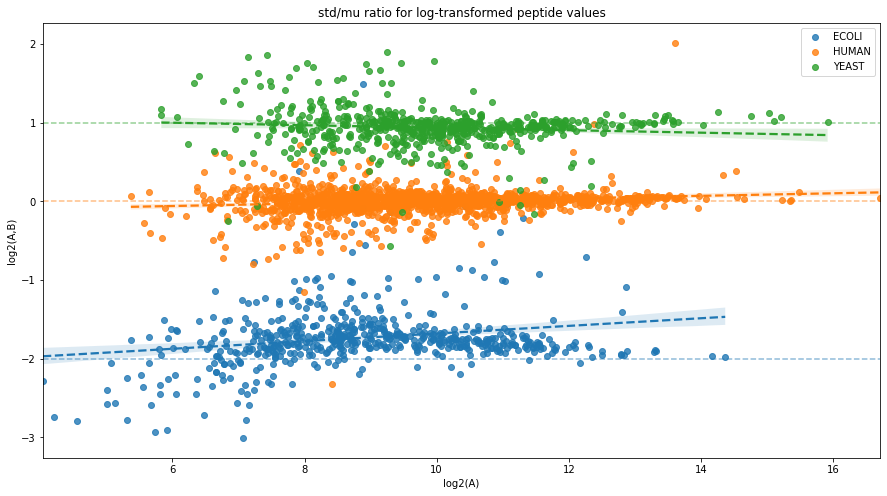

In [267]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_final, x = "log2(B)", y = "log2(A,B)", alpha = 0.7, hue = "specie")
df_final["specie"] = df_final.index.get_level_values("specie")
sns.regplot(data = df_final[df_final.specie == "ECOLI"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI")
sns.regplot(data = df_final[df_final.specie == "HUMAN"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label = "HUMAN")
sns.regplot(data = df_final[df_final.specie == "YEAST"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label = "YEAST")
ax.legend()
ax.axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
#ax.grid()
#plt.legend(labels=['HUMAN (sample 1)', 'YEAST (sample 1)', "ECOLI (sample 1)", "HUMAN (sample 2)", "YEAST (sample 2)", "ECOLI (sample 2)"])
plt.title("std/mu ratio for log-transformed peptide values")

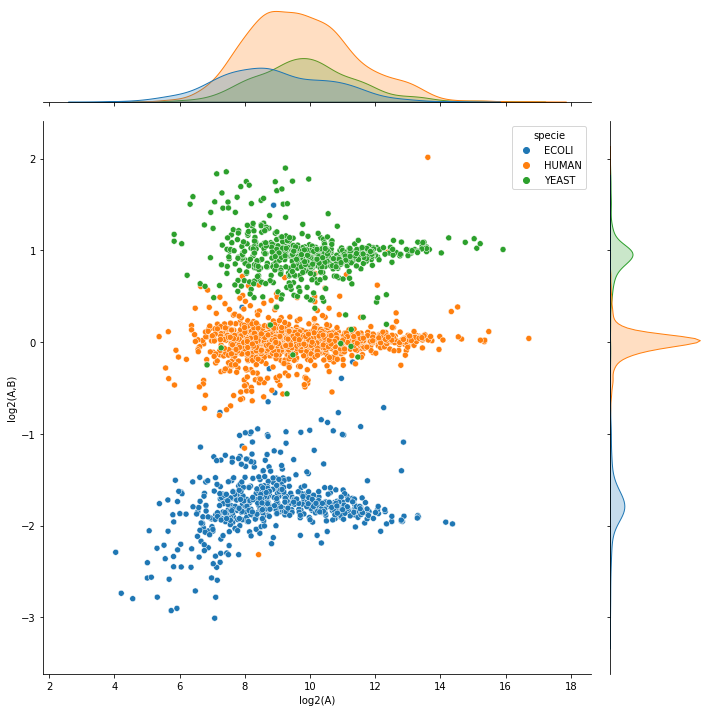

In [268]:

sns.jointplot(data = df_final, x = "log2(A)", y = "log2(A,B)", hue = "specie", height = 10)#, line_kws = {"ls":"--"}, label ="ECOLI")


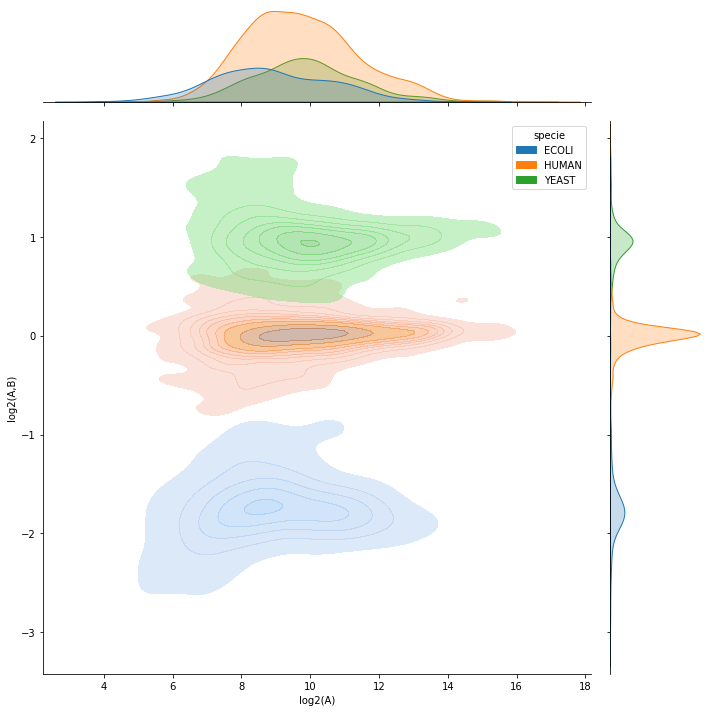

In [269]:
sns.jointplot(data = df_final, x = "log2(A)", y = "log2(A,B)", hue = "specie", kind = "kde", height = 10, 
             fill = True,  joint_kws={'alpha': 0.4})#, line_kws = {"ls":"--"}, label ="ECOLI")

#sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="kde")

In [270]:
df_triq["log2(mu_sample1)"] = np.log2(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]].mean(axis = 1))
df_triq["log2(mu_sample2)"] = np.log2(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]].mean(axis = 1))
df_triq["log2(median_sample1)"] = np.log2(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]].median(axis = 1))
df_triq["log2(median_sample2)"] = np.log2(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]].median(axis = 1))
df_triq["log2(mu_sample1-mu_sample2)"] = (df_triq["log2(mu_sample1)"] - df_triq["log2(mu_sample2)"])


In [271]:
df_triq["mu_sample1"] = np.exp(np.log(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]]).mean(axis = 1))
df_triq["mu_sample2"] = np.exp(np.log(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]]).mean(axis = 1))
df_triq["log2FC"] = (df_triq["mu_sample1"] - df_triq["mu_sample2"])
df_triq["-log2_fold_change"] = -1* df_triq["log2_fold_change"]

In [272]:
### muProtein experiment

df_triq["mu_sample1"] = df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]]


In [273]:
df_triq[df_triq.specie == "ECOLI"]["mu_sample1"] = -df_triq[df_triq.specie == "ECOLI"]["mu_sample1"]

/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [274]:
#def ecoli_sign_correction(x):
#    if x == "ECOLI":
#        return -1
#    else:
#        return 1

#df_triq["ecoli_correction_sign"] = df_triq.specie.map(ecoli_sign_correction)


In [275]:
#df_triq.mu_sample1 = df_triq["ecoli_correction_sign"] * df_triq.mu_sample1

In [276]:
muProtein = -0.003126
df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]]

,1:002-Pedro,1:004-Pedro,1:006-Pedro
0,0.3028,0.2846,0.3009
659,0.3976,0.7182,0.7185
661,0.6581,0.4609,0.6140
664,0.4094,0.8633,0.3704
665,0.4390,0.8609,0.7084
...,...,...,...
935,1.2820,1.4640,1.3830
933,1.2950,1.8310,1.9430
931,1.5300,1.6060,1.5920
927,1.4970,1.3480,1.3710


(-5.0, 5.0)

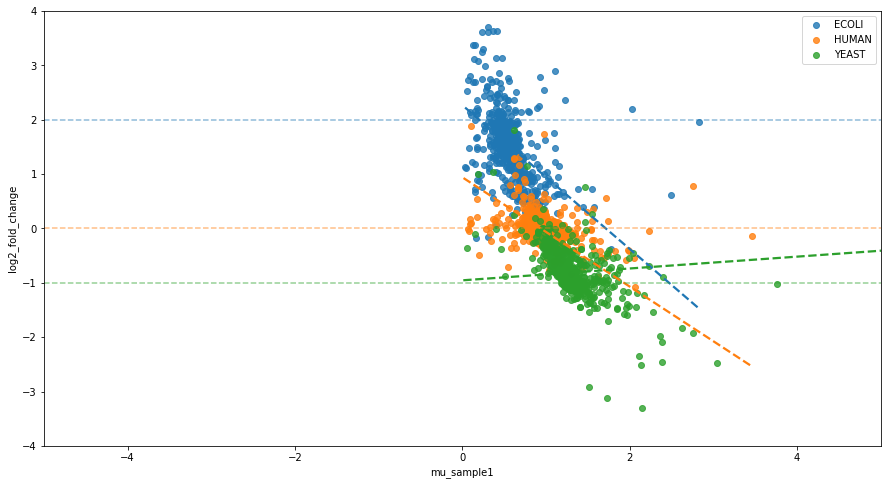

In [277]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.set_ylim([-4, 4])
ax.set_xlim([-5, 5])

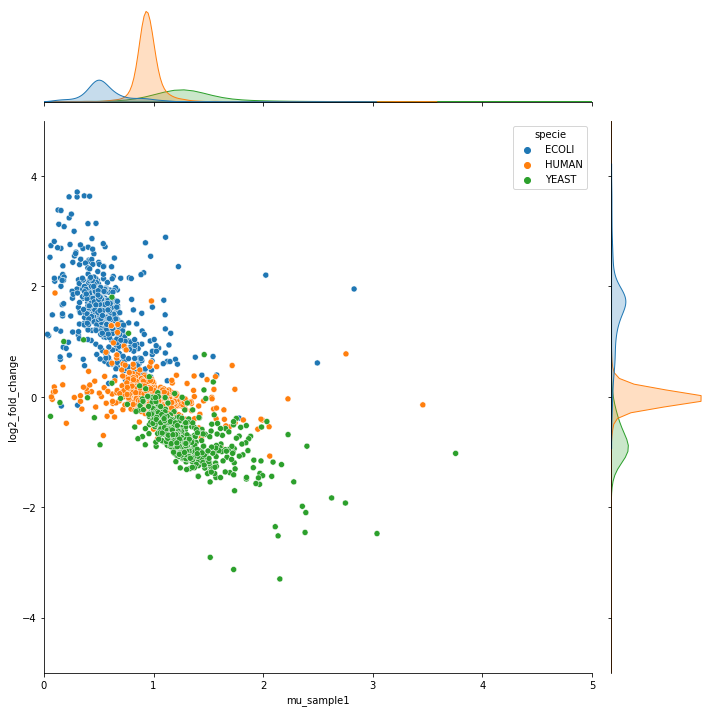

In [278]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "log2_fold_change", hue = "specie", height = 10, 
              xlim = (0,5), ylim = (-5,5))

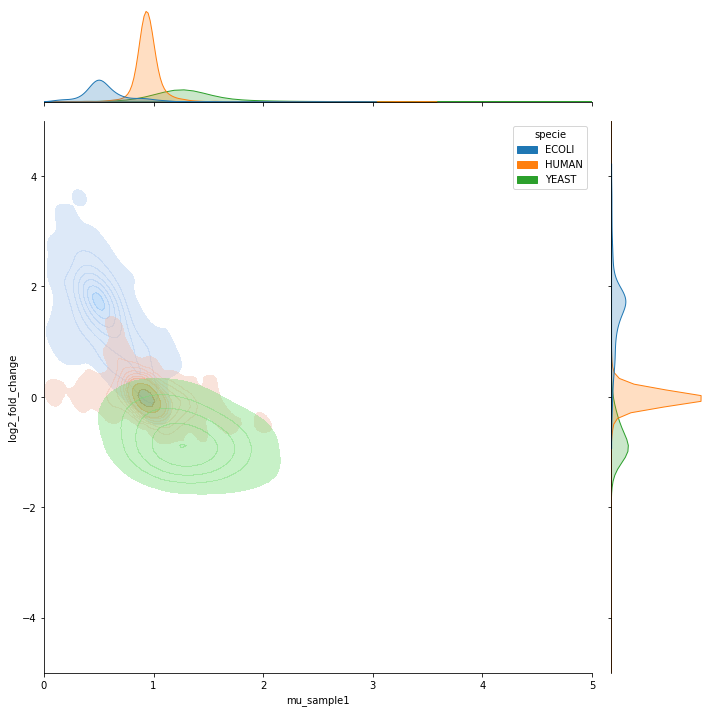

In [279]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "log2_fold_change", hue = "specie", kind = "kde", height = 10, 
              xlim = (0,5), ylim = (-5,5),
             fill = True, joint_kws={'alpha': 0.4})

In [280]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")
msrob_protein = pd.read_csv("msqrobsum_protein_sum_20210817.csv", sep = "\t")
msstat_protein = pd.read_csv("msstat_output_runleveldata.csv", sep = ",")
msstat_run = pd.read_csv("msstats_run.csv", sep = ",")

In [281]:
msrob_protein["sample"].unique()

array(['X002.Pedro', 'X003.Pedro', 'X004.Pedro', 'X005.Pedro',
       'X006.Pedro', 'X007.Pedro'], dtype=object)

In [282]:
msstat_protein.RUN.unique()

array([1, 2, 3, 4, 5, 6])

In [283]:
run_to_replicate_mapper = dict(msstat_run[["Run","BioReplicate"]].values)
run_to_condition_mapper = dict(msstat_run[["Run", "Condition"]].values)
msstat_protein["replicate"] = msstat_protein.RUN.map(run_to_replicate_mapper)
msstat_protein["condition"] = msstat_protein.RUN.map(run_to_condition_mapper)
msrob_protein_sum = msrob_protein.groupby(["proteins", "condition"]).mean()
msrob_sample1 = msrob_protein_sum[msrob_protein_sum.index.get_level_values("condition") == 1].expression.droplevel("condition")
msrob_sample2 = msrob_protein_sum[msrob_protein_sum.index.get_level_values("condition") == 2].expression.droplevel("condition")

#msrob_log2 = np.log2(msrob_sample1) - np.log2(msrob_sample2)
#msrob_log2 = np.log2(msrob_sample2) - np.log2(msrob_sample1)
msrob_log2 = msrob_sample2 - msrob_sample1

In [284]:
msrob_sample1.name = "sample1"
msrob_sample2.name = "sample2"
msrob_log2.name = "log2FC"
msrob_df = pd.concat([msrob_sample1, msrob_sample2, msrob_log2], axis = 1)
species_mapper = lambda x: x.split("_")[-1]
msrob_df["specie"] = msrob_df.index.map(species_mapper)


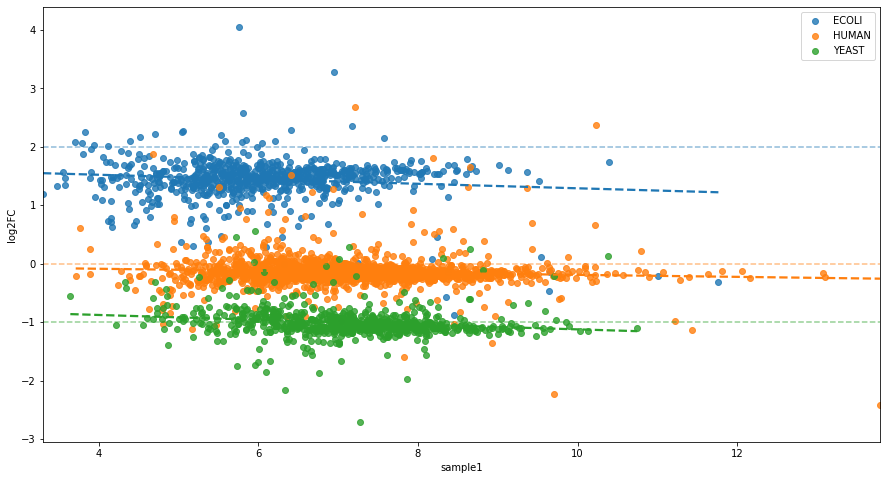

In [285]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*msrob_df[msrob_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
#ax.set_ylim([-5, 3])
#ax.set_xlim([-2, 1])

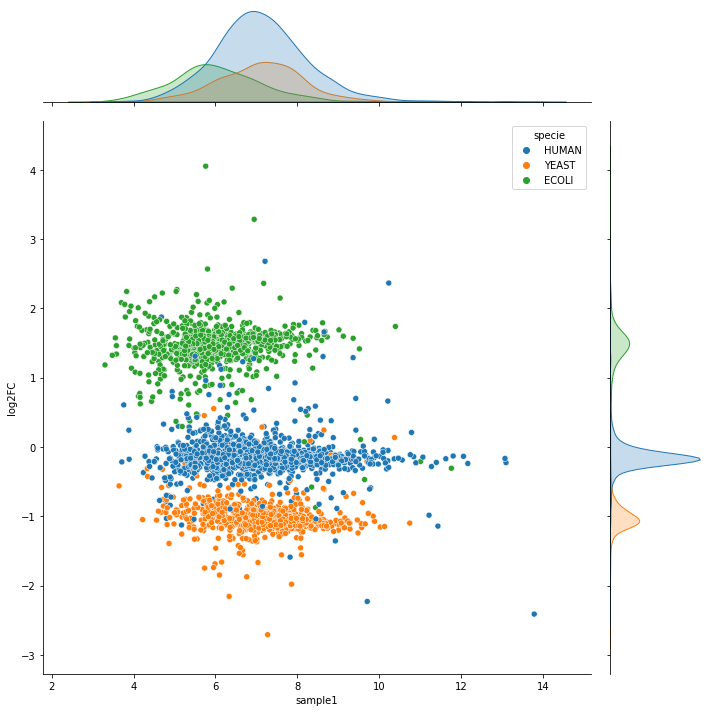

In [286]:
sns.jointplot(data = msrob_df, x = "sample1", y = "log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

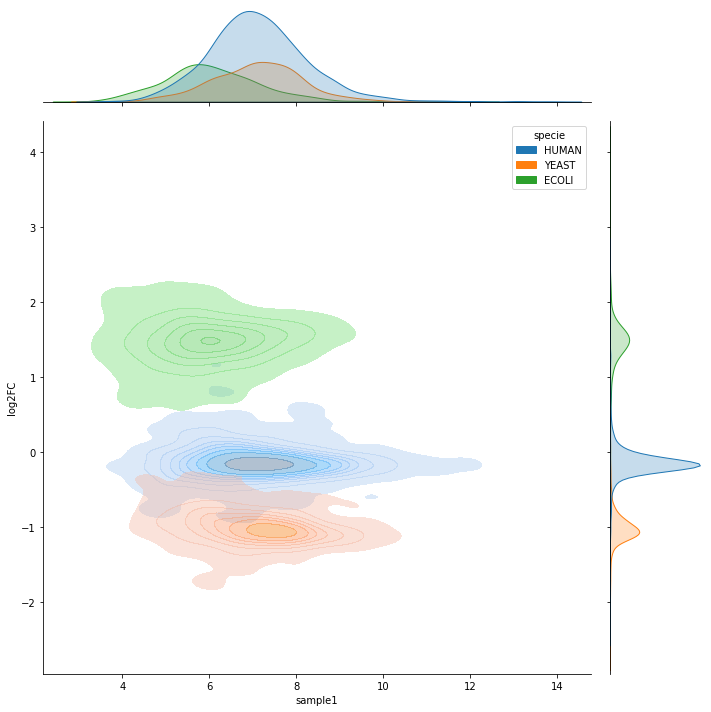

In [287]:
sns.jointplot(data = msrob_df, x = "sample1", y = "log2FC", hue = "specie", height = 10, kind = "kde", 
              fill = True, joint_kws={'alpha': 0.4})

In [288]:
msstat_sum = msstat_protein.groupby(["Protein", "GROUP_ORIGINAL"]).LogIntensities.mean()


In [289]:
msstat_sum_sample1 = msstat_sum[msstat_sum.index.get_level_values("GROUP_ORIGINAL") == 1].droplevel("GROUP_ORIGINAL")
msstat_sum_sample2 = msstat_sum[msstat_sum.index.get_level_values("GROUP_ORIGINAL") == 2].droplevel("GROUP_ORIGINAL")
msstat_log2 = msstat_sum_sample2 - msstat_sum_sample1

msstat_sum_sample1.name = "sample1"
msstat_sum_sample2.name = "sample2"
msstat_log2.name = "log2FC"

In [290]:
msstat_df = pd.concat([msstat_sum_sample1, msstat_sum_sample2, msstat_log2], axis = 1)
msstat_df["specie"] = msstat_df.index.map(specie_mapper)

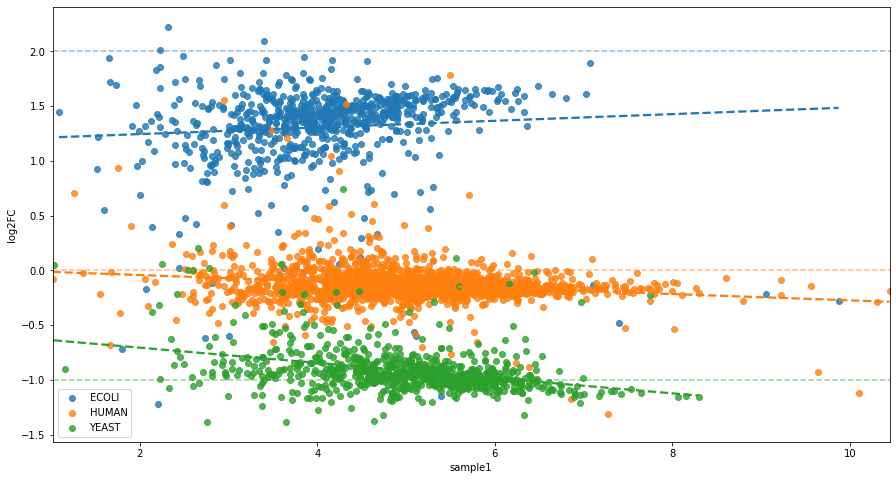

In [291]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*msstat_df[msstat_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
#ax.set_ylim([-5, 3])
#ax.set_xlim([-2, 1])

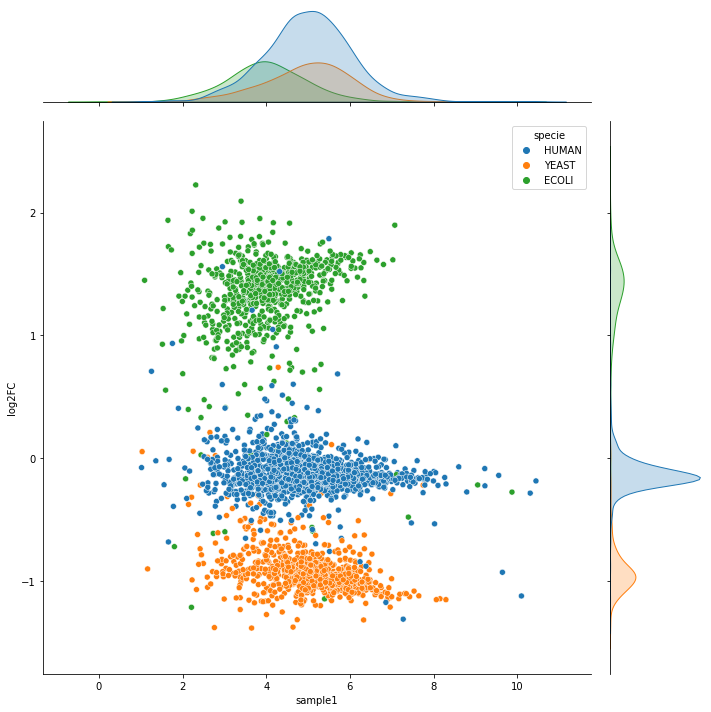

In [292]:
sns.jointplot(data = msstat_df, x = "sample1", y = "log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

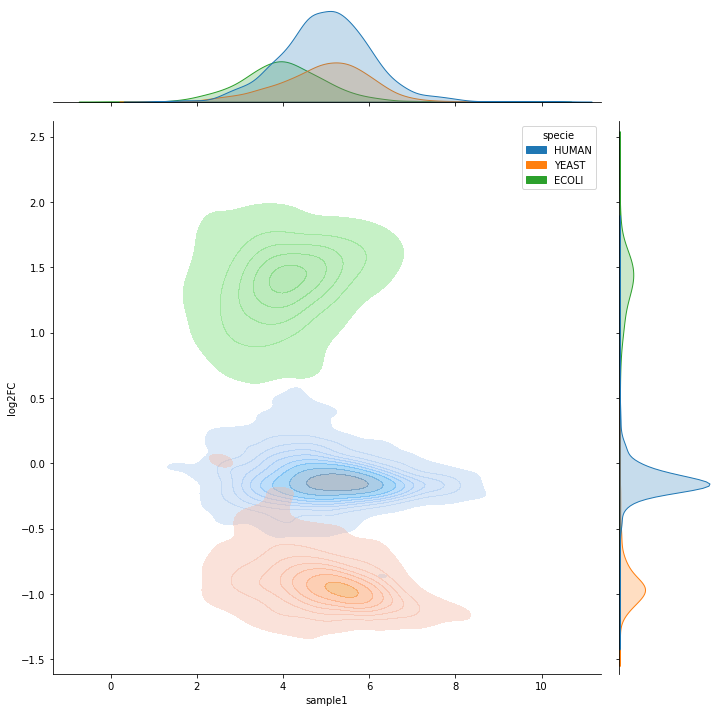

In [293]:
sns.jointplot(data = msstat_df, x = "sample1", y = "log2FC", hue = "specie", height = 10, kind = "kde", 
              fill = True, joint_kws={'alpha': 0.4})

In [294]:
df_triq["mu_sample1"]

0       0.3028
659     0.3976
661     0.6581
664     0.4094
665     0.4390
         ...  
935     1.2820
933     1.2950
931     1.5300
927     1.4970
2012    0.9041
Name: mu_sample1, Length: 3153, dtype: float64

In [295]:
df_triq["-mu_sample1"] = np.log(df_triq["mu_sample1"]).abs()
df_triq["-mu_sample1"]

df_triq["-mu_sample2"] = np.log(df_triq["mu_sample2"]).abs()
df_triq["-mu_sample2"]

0       1.217623
659     0.528009
661     0.560205
664     0.677707
665     0.439262
          ...   
935     0.318125
933     0.509141
931     0.454747
927     0.339181
2012    0.024084
Name: -mu_sample2, Length: 3153, dtype: float64

Text(0.5, 0.98, 'DIANN protein level results')

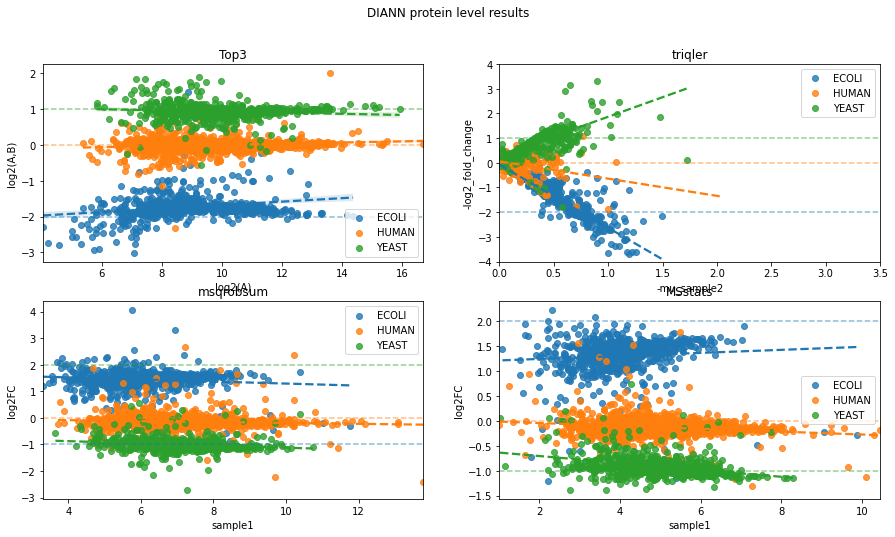

In [296]:

f, ax = plt.subplots(2, 2, figsize = (15,8))

df_final["specie"] = df_final.index.get_level_values("specie")
sns.regplot(data = df_final[df_final.specie == "ECOLI"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label ="ECOLI")
sns.regplot(data = df_final[df_final.specie == "HUMAN"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "HUMAN")
sns.regplot(data = df_final[df_final.specie == "YEAST"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "YEAST")
ax[0,0].legend()
ax[0,0].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,0].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,0].set_title("Top3")

sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[0,1].legend()
ax[0,1].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,1].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,1].set_ylim([-4, 4])
ax[0,1].set_xlim([0, 3.5])
ax[0,1].set_title("triqler")

sns.regplot(data = 1*msrob_df[msrob_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,0].legend()
ax[1,0].axhline(2, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,0].axhline(-1, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,0].set_title("msqrobsum")

sns.regplot(data = 1*msstat_df[msstat_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,1].legend()
ax[1,1].axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,1].axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,1].set_title("MSstats")

plt.suptitle("DIANN protein level results")

In [297]:
from sc

SyntaxError: invalid syntax (<ipython-input-297-12a6a7f69a99>, line 1)

## Scaled  calibration plots 

In [ ]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    ecoli_scaling_factor = []
    yeast_scaling_factor = []
    human_scaling_factor = []
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        ecoli_factor = (df_triq["specie"] == "ECOLI").sum()/(df_triq["specie"] == "HUMAN").sum()
        yeast_factor = (df_triq["specie"] == "YEAST").sum()/(df_triq["specie"] == "HUMAN").sum()
        human_factor = (df_triq["specie"] == "HUMAN").sum()/(df_triq["specie"] == "HUMAN").sum()
        df_triq = df_triq[df_triq.q_value < q_val]
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        ecoli_scaling_factor.append(ecoli_factor) #Should be same for all values because we want the full length of protein list
        yeast_scaling_factor.append(yeast_factor) #Should be same for all values because we want the full length of protein list
        human_scaling_factor.append(human_factor)
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec,
                               human_scaling_factor, yeast_scaling_factor, ecoli_scaling_factor]).T, index = fc_tresh, columns = ["HUMAN", "YEAS8", "ECOLI", "HUMAN_factor", "YEAS8_factor", "ECOLI_factor"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            #print(df)
            try:
                val = list(df[df.index == fc].values[0])
            except:
                print(df)
                break
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI", "HUMAN_factor", "YEAST_factor", "ECOLI_factor"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)


In [ ]:
def get_top3_factor(specie):
    return len(df_final[df_final.index.get_level_values("specie") == specie])/len(df_final[df_final.index.get_level_values("specie") == "HUMAN"])

#triqler_factor() # contained in res from get_DE_for_fcs - triqler read-in funciton

def get_msstat_factor(specie):
    return len(ms[ms["specie"] == specie]) / len(ms[ms["specie"] == "HUMAN"])  

def get_msqrob_factor(specie):
    return len(msqrob[msqrob["specie"] == specie]) / len(msqrob[msqrob["specie"] == "HUMAN"])

In [ ]:
res = get_DE_for_fcs( fcs = [fc])

In [ ]:
#row = 0
#col = 0
#specie = "ECOLI"
#fcs = fcs
#fcs.sort()
#for i in range(20):
#    fc = fcs[i]

def scaled_FP_DE_plot(axs, col, fc, specie):
    top3_factor = get_top3_factor(specie)
    msstat_factor = get_msstat_factor(specie)
    msqrob_factor = get_msqrob_factor(specie)

    
    if specie == "all":
        top3_factor =  get_top3_factor("HUMAN") + get_top3_factor("ECOLI") + get_top3_factor("YEAST")
        msstat_factor = get_msstat_factor("HUMAN") + get_msstat_factor("ECOLI") + get_msstat_factor("YEAST")
        msqrob_factor = get_msqrob_factor("HUMAN") + get_msqrob_factor("ECOLI") + get_msqrob_factor("YEAST")


        df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final, fc_treshold = fc))) * (top3_factor)
        df_triq = ((res[0]["HUMAN"] / 
                   res[0].sum(axis=1))) * (res[0]["HUMAN_factor"]+res[0]["ECOLI_factor"] +res[0]["YEAST_factor"] )
        df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms, fc = fc))) * msstat_factor
        df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob, fc = fc))) * msqrob_factor        
    else:
        df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))) * top3_factor
        df_triq = ((res[0]["HUMAN"] / 
                   res[0][specie])) * res[0][specie + "_factor"]
        df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms[ms.specie == specie], fc = fc))) * msstat_factor
        df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))) * msqrob_factor   

    df_triq.plot(ax = axs[col], style = "b") # triqler data plot
    axs[col].plot(df.index, df.DE, "m") # plot osw top3
    axs[col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
    axs[col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

    axs[col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
    #axs[row, col].set_title(f"fc = {fc}")
    #axs[row, col].set_xlabel("q-value")
    #axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")

    def abline(slope, intercept, col):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axs[col].get_xlim())
        y_vals = intercept + slope * x_vals
        axs[col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
    abline(1,0,col)
    #col+=1
    #if col == 5:
    #    row+=1
    #    col=0
    #plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    #plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
#scaled_FP_DE_plot(axs, col = 0, fc = 0.4, specie = "HUMAN")
#axs[0,0].set_title("HUMAN")
scaled_FP_DE_plot(axs, col = 0, fc = 0.4, specie = "YEAST")
axs[0].set_title("YEAST")
scaled_FP_DE_plot(axs, col = 1, fc = 0.4, specie = "ECOLI")
axs[1].set_title("ECOLI")
scaled_FP_DE_plot(axs, col = 2, fc = 0.4, specie = "all")
axs[2].set_title("all")
plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)


In [ ]:
res_ = get_DE_for_fcs( fcs = [0.4])

In [ ]:
specie

# Volcano

In [ ]:

df_final

In [ ]:
from bioinfokit import analys, visuz

# Top3 

In [ ]:
#fig, axs = plt.subplots(2, 2, figsize=(20,6))
#df_final["-log10(q)"] = -np.log10(df_final.q)
#sns.scatterplot(data = df_final, x = "log2(A,B)", y = "-log10(q)", ax = axs[0,0])
visuz.gene_exp.volcano(df= df_final, lfc = "log2(A,B)", pv="q", show = True, dim = (10, 10), lfc_thr=(0.5, 1) )

# Triqler

In [ ]:
visuz.gene_exp.volcano(df= df_triq, lfc = "log2FC", pv="q_value", show = True, dim = (10, 10), lfc_thr=(0.5, 1))


In [ ]:
visuz.gene_exp.volcano(df= df_triq, lfc = "log2FC", pv="q_value", show = True, dim = (10, 10), xlm=[-5, 5, 1], lfc_thr=(0.5, 1))


# MSqRobSum

In [ ]:
visuz.gene_exp.volcano(df= msqrob, lfc = "logFC", pv="qvalue", show = True, dim = (10, 10), lfc_thr=(1, 0.5))

# MsStat

In [ ]:
visuz.gene_exp.volcano(df= ms[~ms["adj.pvalue"].isna()], lfc = "log2FC", pv="adj.pvalue", show = True, dim = (10, 10), lfc_thr=(1, 0.5))

In [ ]:
help(visuz.gene_exp.volcano)

# Triqler absoluute protein quantifications

(-5.0, 5.0)

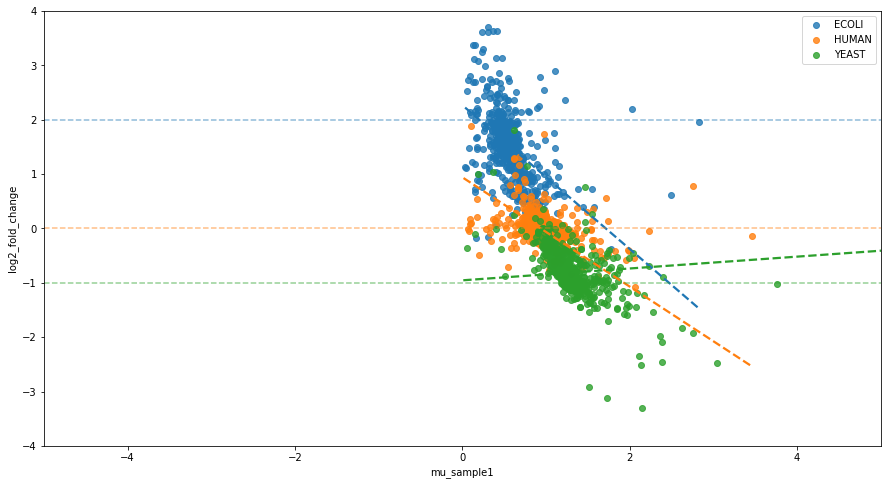

In [298]:
f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.set_ylim([-4, 4])
ax.set_xlim([-5, 5])

In [381]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/py37_triqler_mod_test_20210831")

q_val = 1
file = "fc_1.00"
df_triq = parse_triqler(file)
df_triq["decoy"] = df_triq.protein.map(decoy_mapper)
df_triq = df_triq[df_triq.decoy == False] # remove decoy proteins.
df_triq = df_triq[df_triq.q_value < q_val] # not filtered by q_value
df_triq["specie"] = df_triq.protein.map(specie_mapper)
df_triq.sort_values(by = "specie", inplace = True)
df_triq.log2_fold_change = -df_triq.log2_fold_change


In [382]:
tmp = pd.read_csv("triqler_input_diann_searchScore_Qvalue.csv", sep = "\t")

In [414]:
tmp

,run,condition,charge,searchScore,intensity,peptide,proteins
0,002-Pedro,1,2,9.825093,791.822144,AAAAAAAAAAGAAGGR,Q86U42_HUMAN
1,003-Pedro,2,2,9.464517,773.533447,AAAAAAAAAAGAAGGR,Q86U42_HUMAN
2,004-Pedro,1,2,9.198167,910.519959,AAAAAAAAAAGAAGGR,Q86U42_HUMAN
3,005-Pedro,2,2,9.486911,860.940491,AAAAAAAAAAGAAGGR,Q86U42_HUMAN
4,006-Pedro,1,2,9.324160,909.658081,AAAAAAAAAAGAAGGR,Q86U42_HUMAN
...,...,...,...,...,...,...,...
217888,005-Pedro,2,2,9.391661,289.798309,YYYIPQYK,Q8N183_HUMAN
217889,006-Pedro,1,2,9.324160,362.397034,YYYIPQYK,Q8N183_HUMAN
217890,007-Pedro,2,2,9.220538,338.117950,YYYIPQYK,Q8N183_HUMAN
217891,004-Pedro,1,4,2.363257,50.300472,YYYKFIKCDADLLESR,DECOY_Q70Z53_HUMAN


In [384]:
df_triq_absolute_quantity = pd.read_csv("geoAvgQuantRow.csv", sep = "\t")

In [415]:
df_triq_absolute_quantity

,geomAvg_1:002-Pedro,geomAvg_1:004-Pedro,geomAvg_1:006-Pedro,geomAvg_2:003-Pedro,geomAvg_2:005-Pedro,geomAvg_2:007-Pedro,nonNorm_1:002-Pedro,nonNorm_1:004-Pedro,nonNorm_1:006-Pedro,nonNorm_2:003-Pedro,nonNorm_2:005-Pedro,nonNorm_2:007-Pedro,Unnamed: 13
protein,,,,,,,,,,,,,
A0A1W2PP97_HUMAN,0.940447,0.998693,1.049801,0.977174,1.008991,1.028650,4032.221069,4281.953125,4501.084290,4189.692688,4326.106873,4410.394897,NaN
A0FGR8_HUMAN,0.890064,0.957454,1.085136,0.990853,1.018598,1.071432,1265.588966,1637.008563,1855.311713,1886.701690,1939.532132,1831.881551,NaN
A1L0T0_HUMAN,0.978867,0.946986,0.972034,1.032340,1.026478,1.047317,542.938057,525.254980,539.148142,572.597259,569.345831,580.904559,NaN
A5YKK6_HUMAN,0.949499,1.058813,0.910920,1.088704,1.075355,0.932705,643.105629,717.145647,616.976063,737.390717,728.349089,631.731037,NaN
A5Z2X5_YEAST,1.269363,1.501834,1.451685,0.678998,0.706671,0.753068,2455.463540,2905.155336,2808.147168,1313.456978,1366.988839,1456.739075,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y697_HUMAN,0.764354,1.247186,1.385546,0.815219,0.958868,0.968545,191.363539,312.245156,346.884950,204.098081,240.061917,242.484582,NaN
Q9Y6A9_HUMAN,0.921316,1.040331,1.173757,0.898151,0.953146,1.038324,1224.962387,1383.201599,1560.603027,1194.163208,1267.283020,1380.533295,NaN
Q9Y6C9_HUMAN,0.897604,1.116286,1.172258,0.919764,0.856805,1.080334,1117.699038,1390.001994,1459.698356,1145.292743,1066.896171,1345.235012,NaN


In [386]:
df_triq

,protein,peptides,q_value,posterior_error_prob,num_peptides,protein_id_posterior_error_prob,log2_fold_change,diff_exp_prob_1.0,1:002-Pedro,1:004-Pedro,1:006-Pedro,2:003-Pedro,2:005-Pedro,2:007-Pedro,decoy,specie
0,P0A887_ECOLI,AYDAYSFHVLPR;FTIDCSGVR;IGSLVANDADSYR;LLVLEFSKP...,7.704000e-07,7.704000e-07,5.0,8.579000e-09,2.2290,7.618000e-07,0.3579,0.4968,0.5092,2.0420,2.2240,2.4320,False,ECOLI
481,P0A7G2_ECOLI,EIALILQR;IVPELTFFYDNSLVEGMR;LGMMTTVSGVEMSR;MSN...,2.304000e-04,2.363000e-03,4.0,6.214000e-08,1.4910,2.363000e-03,0.5275,0.6554,0.6211,1.5050,1.7350,1.7830,False,ECOLI
482,P37051_ECOLI,FDIPFELVSHEGLTR;MADAIDAYQPDYVVLAK,2.360000e-04,2.893000e-03,2.0,2.913000e-05,1.5570,2.864000e-03,0.6026,0.6988,0.4485,1.6990,1.7400,1.7910,False,ECOLI
483,P76576_ECOLI,AAAQLQQGLADTSDENLK;SASLAYQNAVTAVSEGKPDSIPAAEK,2.419000e-04,3.123000e-03,2.0,2.913000e-05,1.5830,3.093000e-03,0.5050,0.5594,0.6534,1.7330,1.8070,1.7300,False,ECOLI
484,P20605_ECOLI,AATIELGPLVR;LEQAAYEMTALR,2.479000e-04,3.123000e-03,2.0,2.913000e-05,1.6990,3.094000e-03,0.6307,0.6992,0.4111,1.6250,1.8420,1.8430,False,ECOLI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,P53337_YEAST,IEGLTDNAVVYK;SNQNQSTSGILK,2.587000e-01,8.540000e-01,2.0,2.913000e-05,-0.8628,8.540000e-01,1.2010,1.4200,1.4360,0.7616,0.7756,0.6911,False,YEAST
1213,A5Z2X5_YEAST,LTGNPELSSLDEVLAK;LTGNPELSSLDEVLAKDKD,2.582000e-01,8.531000e-01,2.0,2.913000e-05,-0.8549,8.531000e-01,1.2120,1.4340,1.3890,0.7145,0.7387,0.7847,False,YEAST
1212,P32860_YEAST,LQGACTSCSSSEVTLK,2.578000e-01,8.531000e-01,1.0,1.359000e-02,-0.7583,8.510000e-01,1.1230,1.4780,1.4880,0.7351,0.6034,0.9130,False,YEAST
1288,P39077_YEAST,MQAPVVFMNASQER;HAQGNFTTGIDGDKGK;KGESQTNIEIEKEE...,2.949000e-01,9.135000e-01,9.0,4.660000e-11,-0.8587,9.135000e-01,1.1930,1.4160,1.4000,0.6969,0.7542,0.8037,False,YEAST


In [387]:
#bool(set(df_triq.protein) & set(df_triq_absolute_quantity.Protein))
len(set(df_triq.protein).intersection( set(df_triq_absolute_quantity.protein)))

3280

In [389]:
#df_triq_absolute_quantity[df_triq_absolute_quantity.Protein == "P53337_YEAST"]

In [390]:
df_triq[df_triq.protein == "P53337_YEAST"]

,protein,peptides,q_value,posterior_error_prob,num_peptides,protein_id_posterior_error_prob,log2_fold_change,diff_exp_prob_1.0,1:002-Pedro,1:004-Pedro,1:006-Pedro,2:003-Pedro,2:005-Pedro,2:007-Pedro,decoy,specie
1214,P53337_YEAST,IEGLTDNAVVYK;SNQNQSTSGILK,0.2587,0.854,2.0,0.000029,-0.8628,0.854,1.201,1.42,1.436,0.7616,0.7756,0.6911,False,YEAST


In [391]:
df_triq.set_index("protein", inplace = True)

In [392]:
df_triq_absolute_quantity.set_index("protein", inplace = True)

In [393]:
df_triq = pd.concat([df_triq, df_triq_absolute_quantity], axis = 1)

In [394]:
df_triq

,peptides,q_value,posterior_error_prob,num_peptides,protein_id_posterior_error_prob,log2_fold_change,diff_exp_prob_1.0,1:002-Pedro,1:004-Pedro,1:006-Pedro,...,geomAvg_2:003-Pedro,geomAvg_2:005-Pedro,geomAvg_2:007-Pedro,nonNorm_1:002-Pedro,nonNorm_1:004-Pedro,nonNorm_1:006-Pedro,nonNorm_2:003-Pedro,nonNorm_2:005-Pedro,nonNorm_2:007-Pedro,Unnamed: 13
protein,,,,,,,,,,,,,,,,,,,,,
P0A887_ECOLI,AYDAYSFHVLPR;FTIDCSGVR;IGSLVANDADSYR;LLVLEFSKP...,7.704000e-07,7.704000e-07,5.0,8.579000e-09,2.2290,7.618000e-07,0.3579,0.4968,0.5092,...,1.870991,2.045094,2.103327,228.020675,349.658466,512.758644,1361.604768,1488.307061,1530.686390,NaN
P0A7G2_ECOLI,EIALILQR;IVPELTFFYDNSLVEGMR;LGMMTTVSGVEMSR;MSN...,2.304000e-04,2.363000e-03,4.0,6.214000e-08,1.4910,2.363000e-03,0.5275,0.6554,0.6211,...,1.603602,1.763139,1.837972,627.705000,732.418878,735.890361,1935.440311,2127.991034,2218.309256,NaN
P37051_ECOLI,FDIPFELVSHEGLTR;MADAIDAYQPDYVVLAK,2.360000e-04,2.893000e-03,2.0,2.913000e-05,1.5570,2.864000e-03,0.6026,0.6988,0.4485,...,1.697923,1.738570,1.790176,401.873469,301.719914,189.827747,1258.203846,1288.324131,1326.566066,NaN
P76576_ECOLI,AAAQLQQGLADTSDENLK;SASLAYQNAVTAVSEGKPDSIPAAEK,2.419000e-04,3.123000e-03,2.0,2.913000e-05,1.5830,3.093000e-03,0.5050,0.5594,0.6534,...,1.893548,1.904273,1.861654,167.157030,173.420670,256.414795,672.218138,676.025698,660.895491,NaN
P20605_ECOLI,AATIELGPLVR;LEQAAYEMTALR,2.479000e-04,3.123000e-03,2.0,2.913000e-05,1.6990,3.094000e-03,0.6307,0.6992,0.4111,...,1.694323,1.952313,1.908565,833.271602,697.429904,471.034542,2033.262919,2342.863102,2290.362838,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P53337_YEAST,IEGLTDNAVVYK;SNQNQSTSGILK,2.587000e-01,8.540000e-01,2.0,2.913000e-05,-0.8628,8.540000e-01,1.2010,1.4200,1.4360,...,0.735369,0.746766,0.668352,1635.049913,1949.954370,1998.083120,976.023258,991.149852,887.074939,NaN
A5Z2X5_YEAST,LTGNPELSSLDEVLAK;LTGNPELSSLDEVLAKDKD,2.582000e-01,8.531000e-01,2.0,2.913000e-05,-0.8549,8.531000e-01,1.2120,1.4340,1.3890,...,0.678998,0.706671,0.753068,2455.463540,2905.155336,2808.147168,1313.456978,1366.988839,1456.739075,NaN
P32860_YEAST,LQGACTSCSSSEVTLK,2.578000e-01,8.531000e-01,1.0,1.359000e-02,-0.7583,8.510000e-01,1.1230,1.4780,1.4880,...,0.666984,0.524559,0.885016,247.036667,346.306114,348.793259,139.958468,110.072174,185.709763,NaN


In [395]:
prefix = "nonNorm_"
#prefix = "geomAvg_"
df_triq["log2(mu_sample1)"] = np.log2(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].mean(axis = 1))
df_triq["log2(mu_sample2)"] = np.log2(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].mean(axis = 1))
df_triq["log2(median_sample1)"] = np.log2(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].median(axis = 1))
df_triq["log2(median_sample2)"] = np.log2(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].median(axis = 1))
df_triq["log2(max_sample1)"] = np.log2(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].max(axis = 1))
df_triq["log2(max_sample2)"] = np.log2(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].max(axis = 1))

df_triq["log2(mu_sample1-mu_sample2)"] = (df_triq["log2(mu_sample1)"] - df_triq["log2(mu_sample2)"])
df_triq["log2(median_sample1-median_sample2)"] = (df_triq["log2(median_sample1)"] - df_triq["log2(median_sample2)"])
df_triq["log2(max_sample1-max_sample2)"] = (df_triq["log2(max_sample1)"] - df_triq["log2(max_sample2)"])



#df_triq["mu_sample1"] = np.exp(np.log(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]]).mean(axis = 1))
#df_triq["mu_sample2"] = np.exp(np.log(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]]).mean(axis = 1))
#df_triq["median_sample1"] = np.exp(np.log(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]]).median(axis = 1))
#df_triq["median_sample2"] = np.exp(np.log(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]]).median(axis = 1))
#df_triq["max_sample1"] = np.exp(np.log(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]]).max(axis = 1))
#df_triq["max_sample2"] = np.exp(np.log(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]]).max(axis = 1))
#df_triq["mu_log2FC"] = np.log(df_triq["mu_sample1"]) - np.log(df_triq["mu_sample2"])
#df_triq["median_log2FC"] = np.log(df_triq["median_sample1"]) - np.log(df_triq["median_sample2"])
#df_triq["max_log2FC"] = np.log(df_triq["max_sample1"]) - np.log(df_triq["max_sample2"])

df_triq["mu_sample1"] = df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].mean(axis = 1)
df_triq["mu_sample2"] = df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].mean(axis = 1)
df_triq["median_sample1"] = df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].median(axis = 1)
df_triq["median_sample2"] = df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].median(axis = 1)
df_triq["max_sample1"] = df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].max(axis = 1)
df_triq["max_sample2"] = df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].max(axis = 1)
df_triq["mu_log2FC"] = df_triq["mu_sample1"] - df_triq["mu_sample2"]
df_triq["median_log2FC"] = df_triq["median_sample1"] - df_triq["median_sample2"]
df_triq["max_log2FC"] = df_triq["max_sample1"] - df_triq["max_sample2"]



df_triq["-log2_fold_change"] = -1* df_triq["log2_fold_change"]

# Non-KDE style plot

# log2 quantities - triqler fc

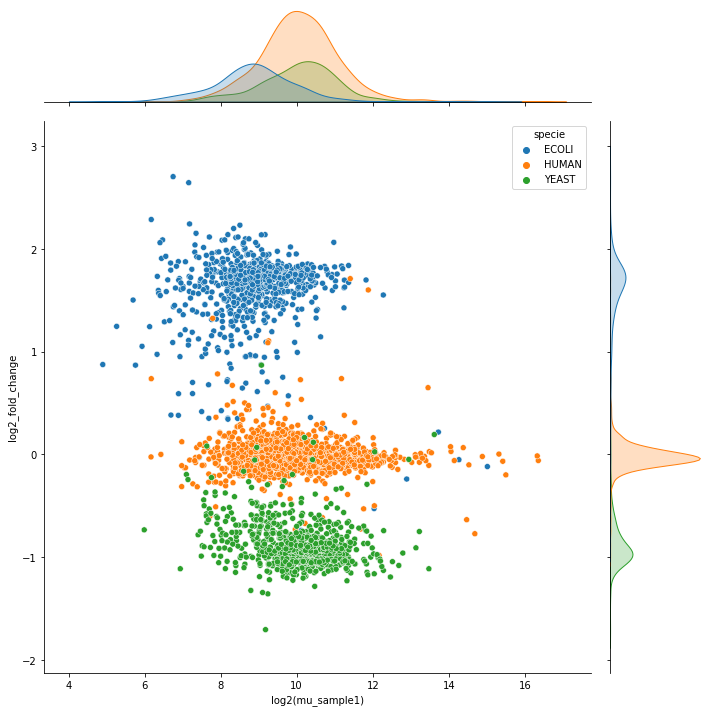

In [396]:
sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2_fold_change", hue = "specie", height = 10)#, 
              #xlim = (-5,5), ylim = (-5,5))

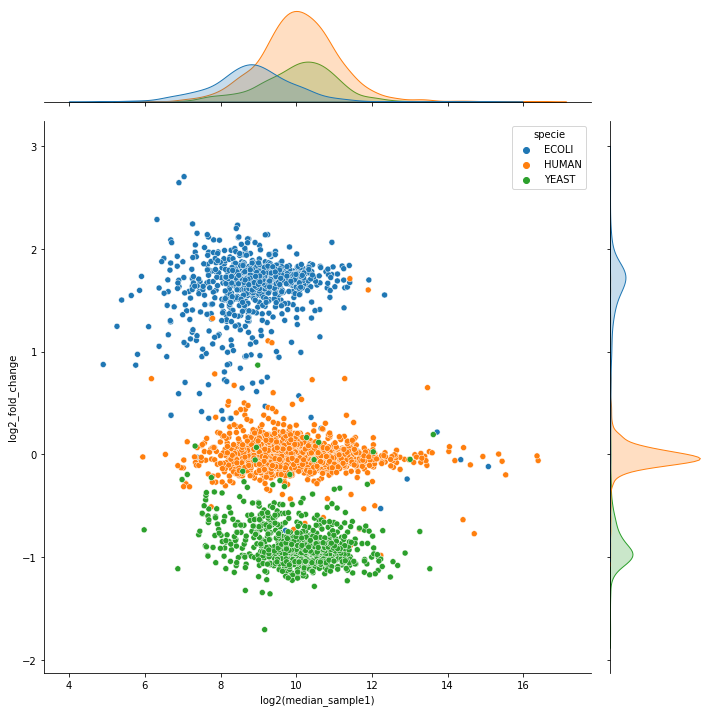

In [397]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2_fold_change", hue = "specie", height = 10)#, 
              #xlim = (0,5), ylim = (-5,5))

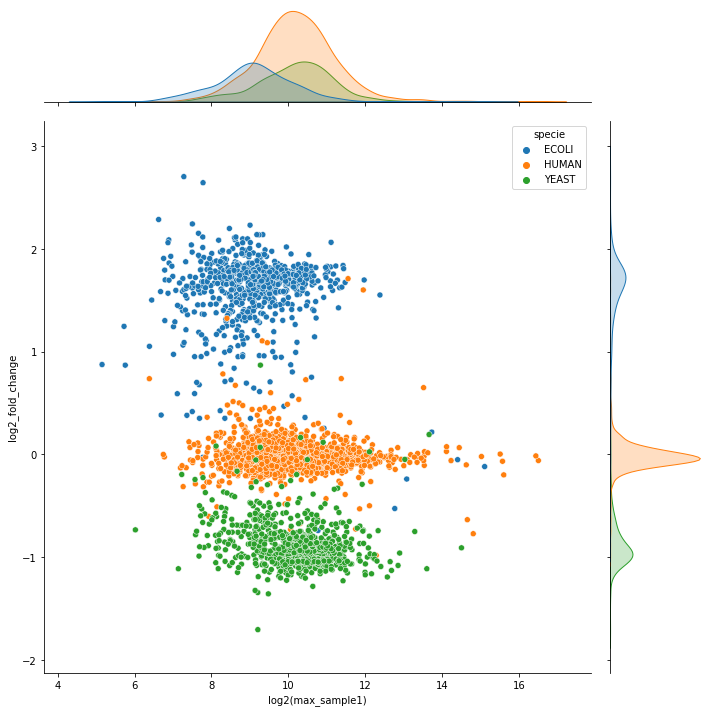

In [398]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2_fold_change", hue = "specie", height = 10)#, 
              #xlim = (0,5), ylim = (-5,5))

# log2 quantities 

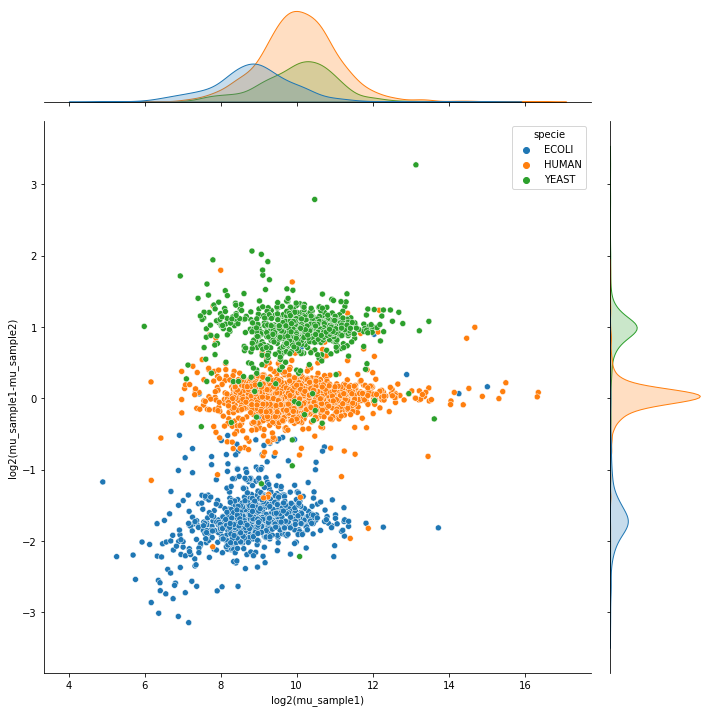

In [399]:
sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2(mu_sample1-mu_sample2)", hue = "specie", height = 10)#, 
              #xlim = (0,5), ylim = (-5,5))

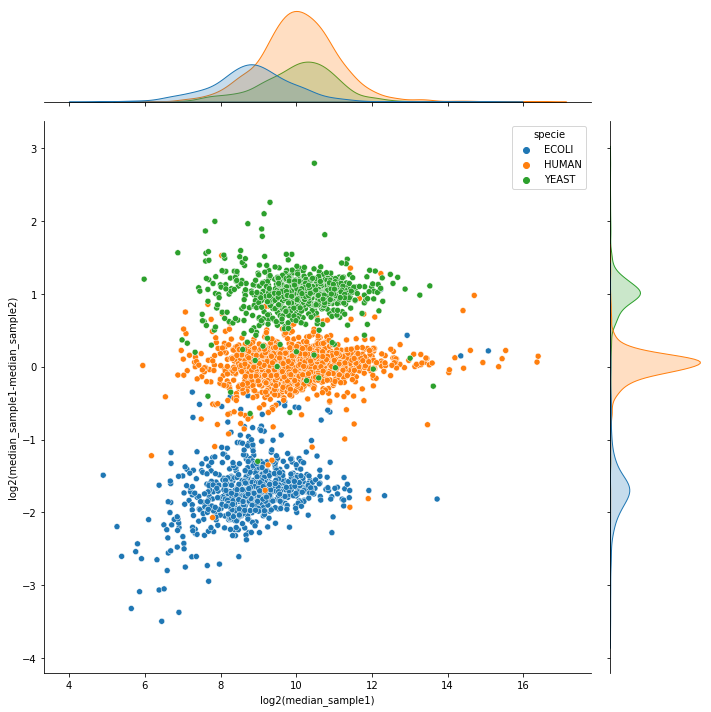

In [400]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2(median_sample1-median_sample2)", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

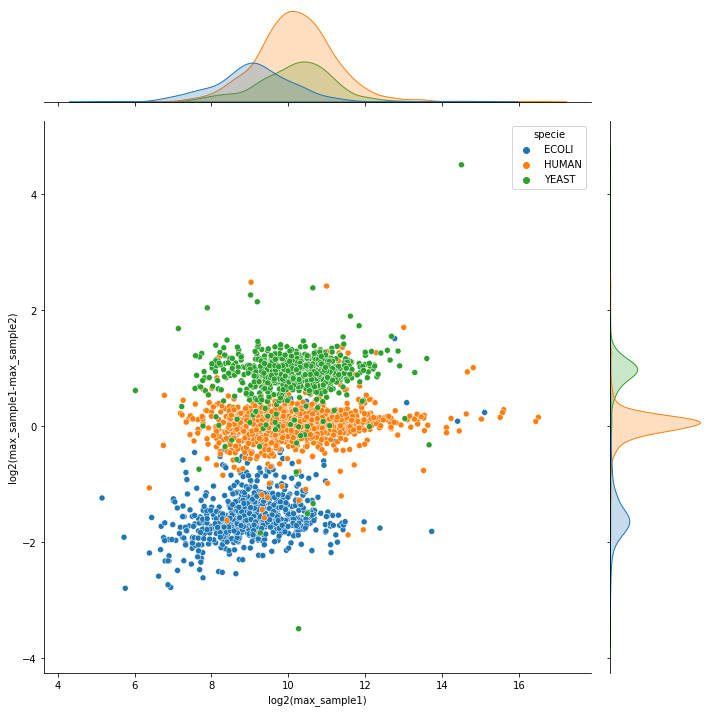

In [401]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2(max_sample1-max_sample2)", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

# no log2  - triqler fc

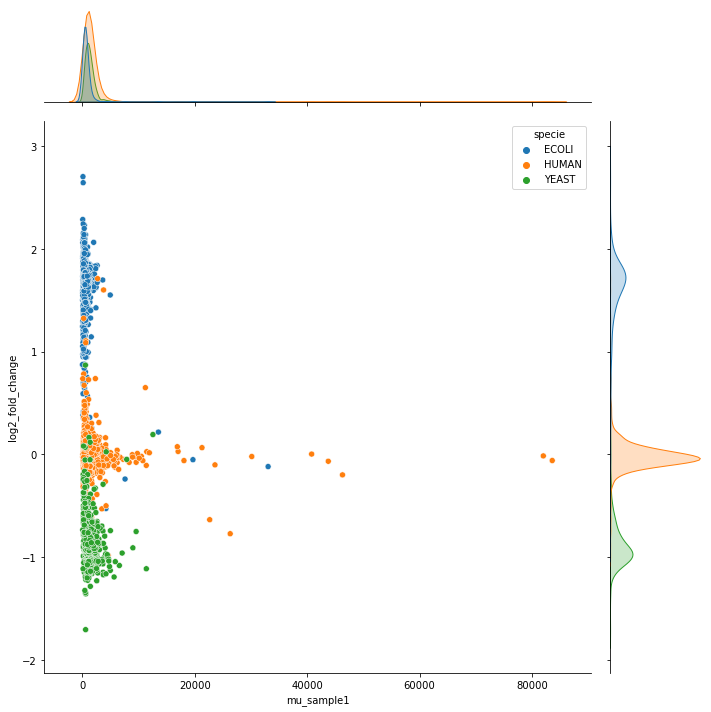

In [402]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "log2_fold_change", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

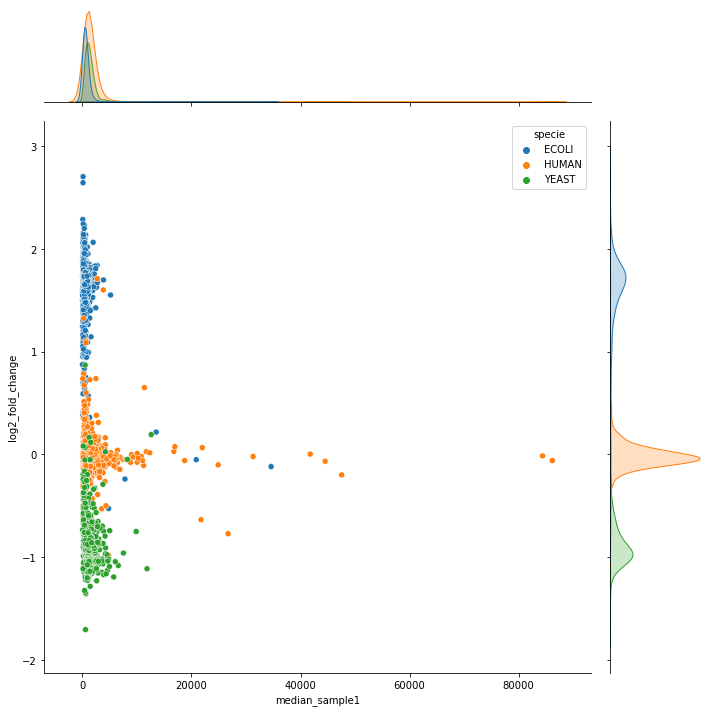

In [403]:
sns.jointplot(data = df_triq, x = "median_sample1", y = "log2_fold_change", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

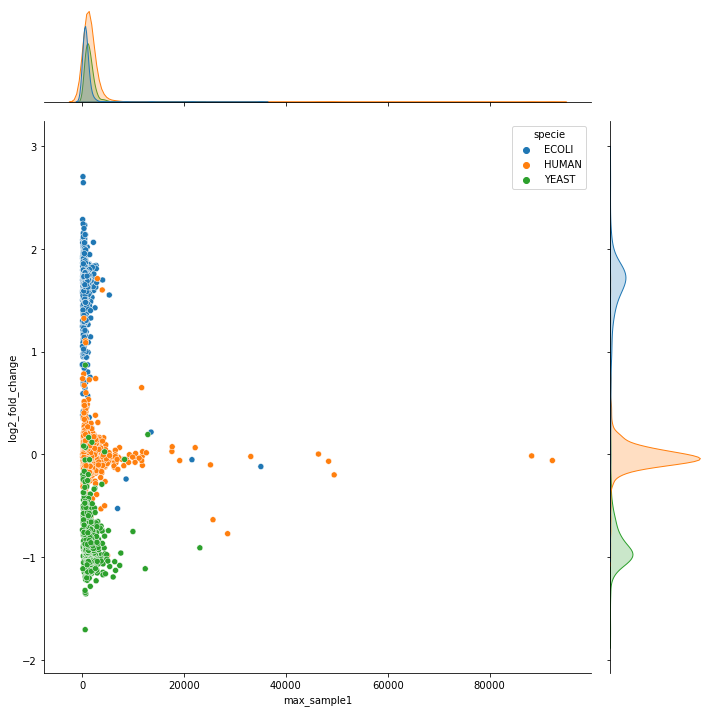

In [404]:
sns.jointplot(data = df_triq, x = "max_sample1", y = "log2_fold_change", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

# no log2 

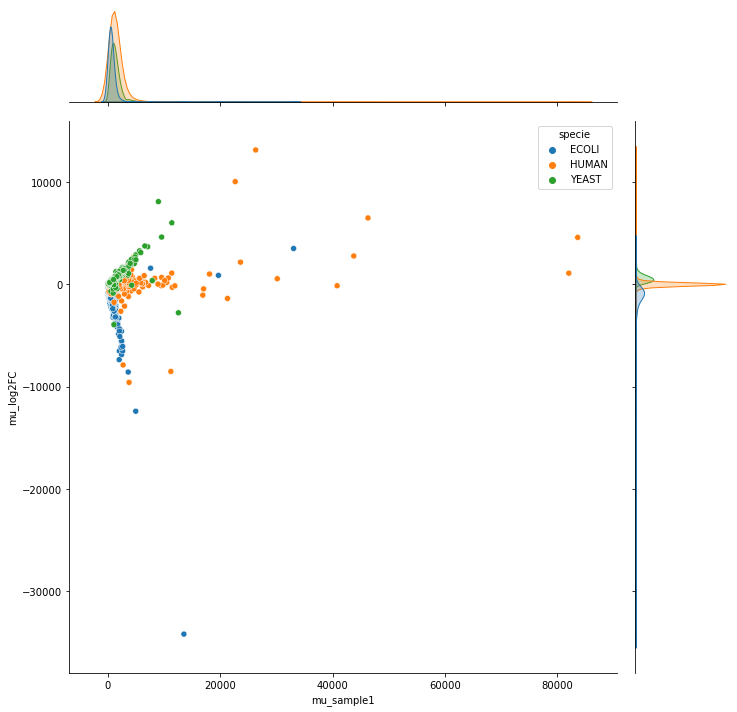

In [405]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "mu_log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

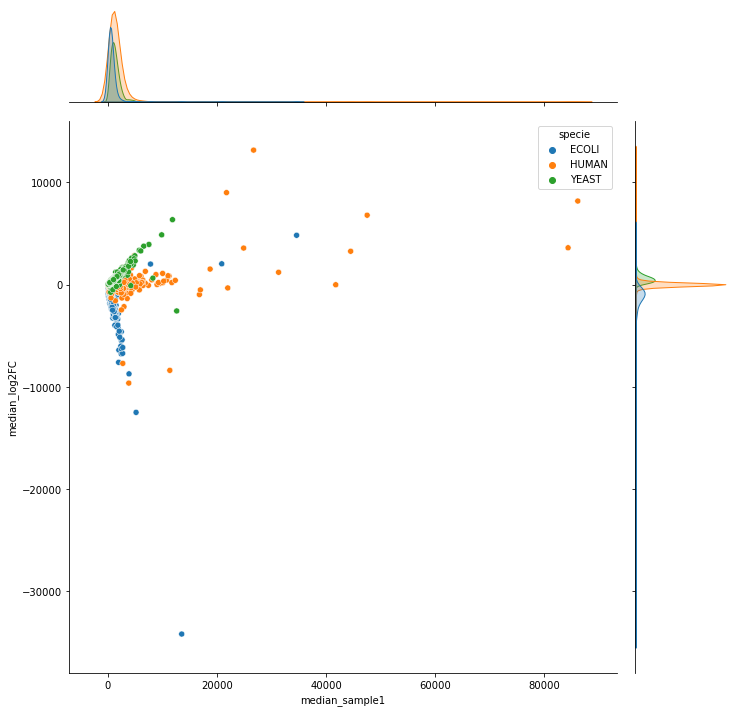

In [406]:
sns.jointplot(data = df_triq, x = "median_sample1", y = "median_log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

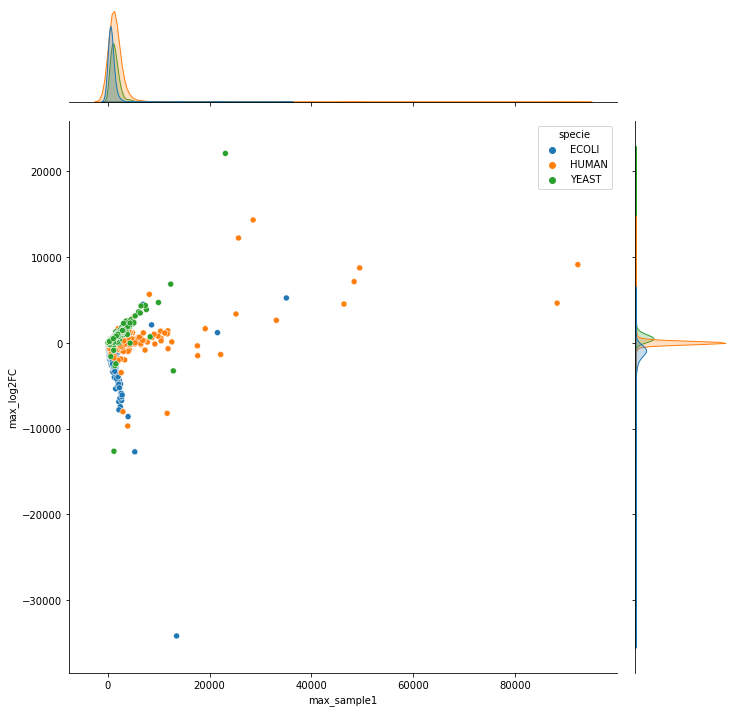

In [407]:
sns.jointplot(data = df_triq, x = "max_sample1", y = "max_log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

# kde style plots

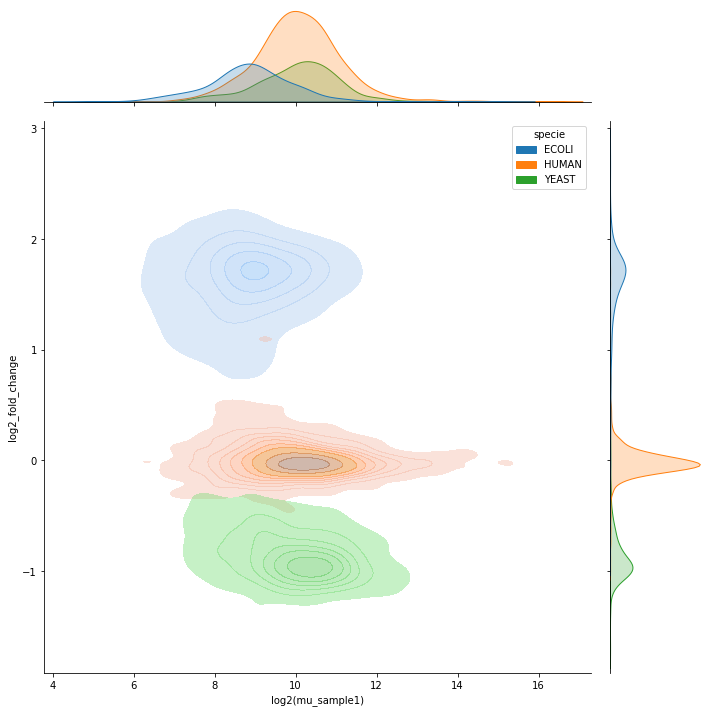

In [408]:
sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2_fold_change", hue = "specie", height = 10, 
              kind = "kde", fill = True, joint_kws={'alpha': 0.4} )#, 
              #xlim = (-5,5), ylim = (-5,5))

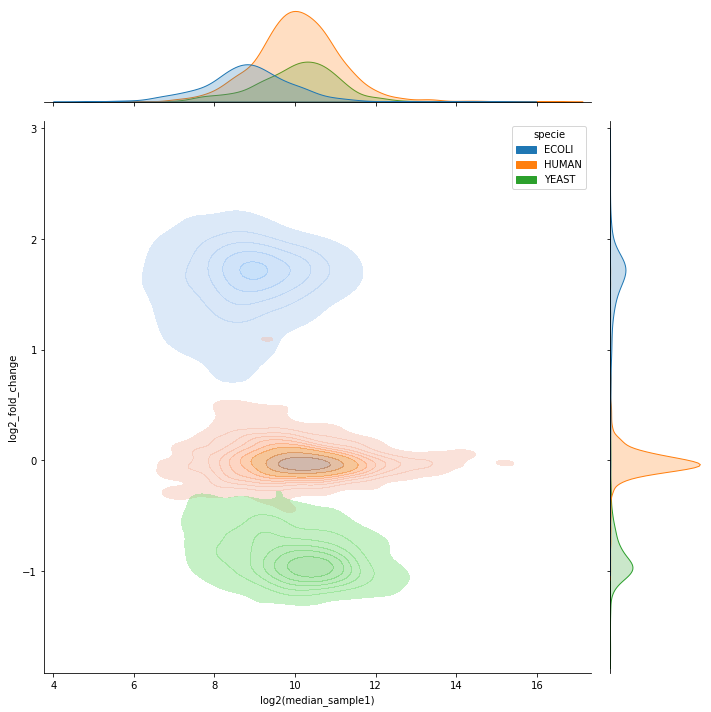

In [409]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2_fold_change", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
              #xlim = (0,5), ylim = (-5,5))

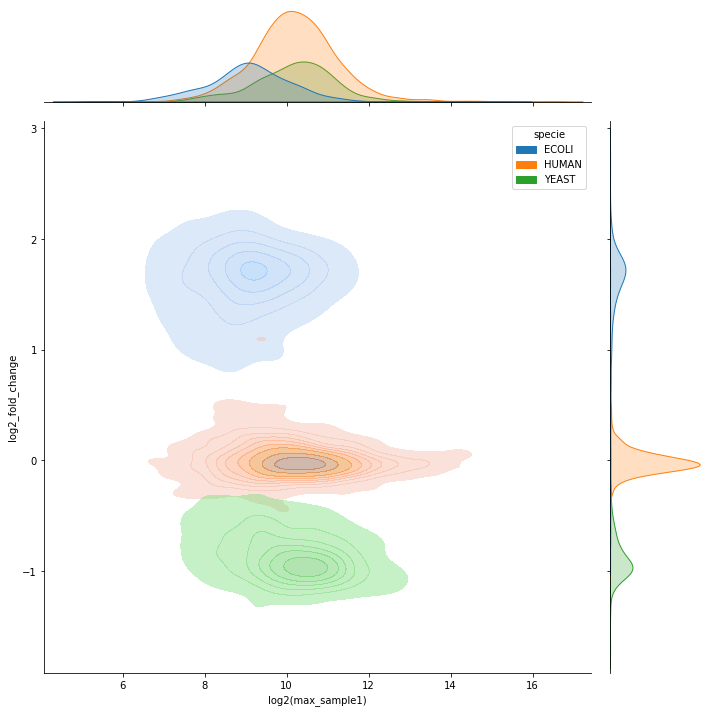

In [410]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2_fold_change", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
              #xlim = (0,5), ylim = (-5,5))

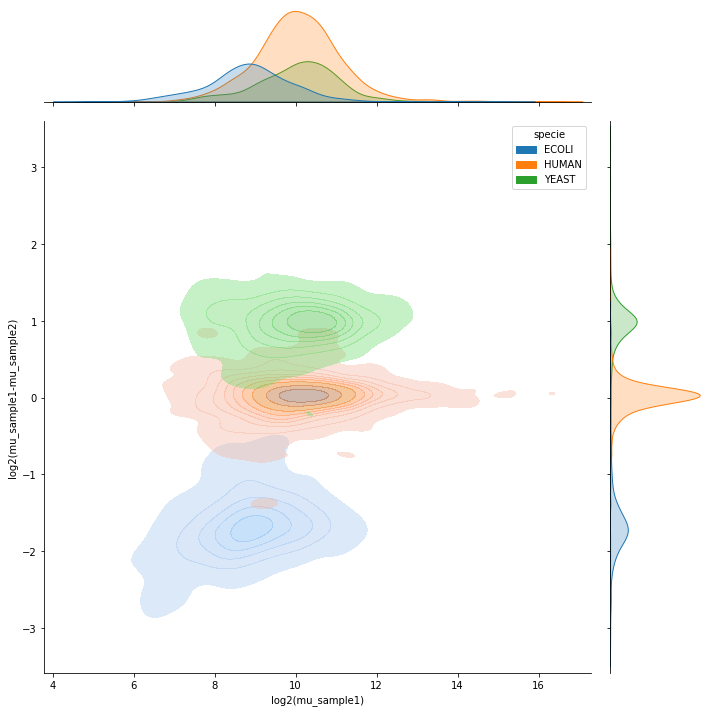

In [411]:
sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2(mu_sample1-mu_sample2)", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
              #xlim = (0,5), ylim = (-5,5))

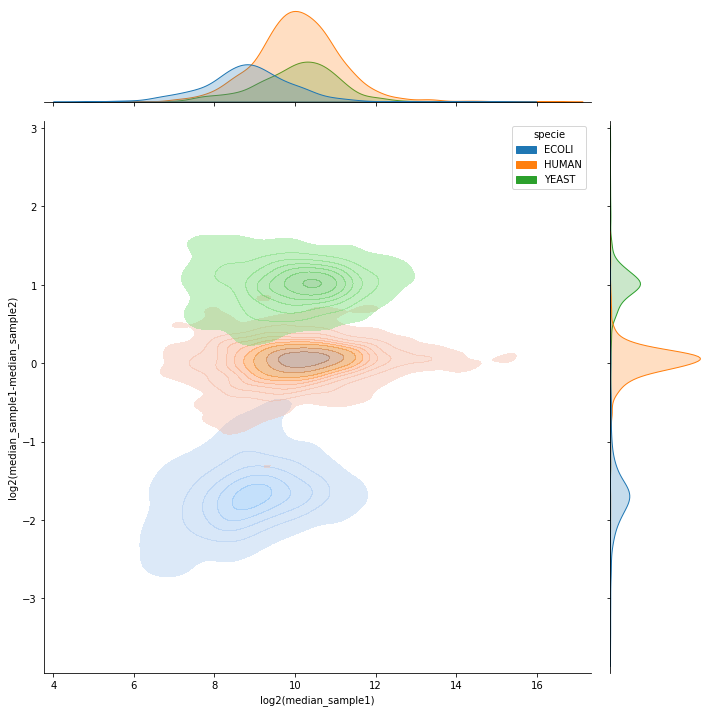

In [412]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2(median_sample1-median_sample2)", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4}
             )#, 
#              xlim = (0,5), ylim = (-5,5))

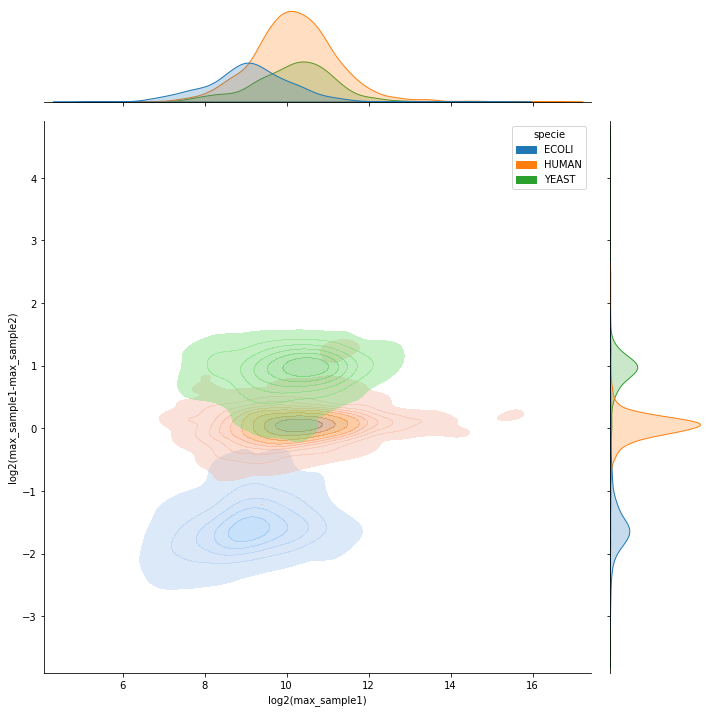

In [413]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2(max_sample1-max_sample2)", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
#              xlim = (0,5), ylim = (-5,5))